In [1]:
# PTT title generator from content base on seq2seq model.
import pandas as pd
import numpy as np
import csv
import os
import types 

#Initialize for files name and path.
base_dir = 'E:/Raw data/PTT'
totalboard_name = 'BG-CC-MV-SX-TJ-WT'
board_name = ['Boy-Girl','C_Chat','movie','sex','Tech_job','WomenTalk']
board_dict_index = {'Boy-Girl':0,'C_Chat':1,'movie':2,'sex':3,'Tech_job':4,'WomenTalk':5}

build_vocab = False
label_newnum = len(board_name)
max_word_length = 250+2
min_word_length = 100
max_push_length = 100+2
words_limit = 30000
filters_char='"#()*-/;[\]^_`{|}~\t\n'
#filters_char='ˊˋ#*×/\\^_`|＼﹨｜〝〞‵′＊／－-≦≧＿＃⌒‿．§◎˙※ㄧ↔│ꄊ✂☁☛✈♥○●☆★◇◆□■▽▼△▲㊣⊙⊕ˍ…﹌﹋﹎﹍﹉﹊‥–↑↓←→↖↗↙↘∥∕℅≒≡∩∪∞￣＿◤◥◣◢∵∴〒⊥∠⊿┼┴┬┤├▔─│▕┌┐└┘╭╮╰╯═╞╪╡╔╦╗╠╬╣╚╩╝╒╤╕╘╧╛╓╥╖╟╫╢╙╨╜║▓░▒╱╲╳▁━▶▁▂▃▄▅▆▇█▉▊▋▋▌▍▎▏▐▔■▁▔'

SOS_id = '<sos>' #解碼器端的句子起始標識符。
EOS_id = '<eos>' #解碼器端的句子結束標識符。
UNK_id = '<unk>' #低頻詞或者一些未遇到過的詞等。
PAD_id = '<pad>' #補全字符。

new_content_dir = []
new_push_dir = []
mdl_dir = os.path.join(base_dir, 'model')
if not os.path.exists(mdl_dir):
    os.makedirs(mdl_dir)
totalboard_dir = os.path.join(base_dir, totalboard_name)
if not os.path.exists(totalboard_dir):
    os.makedirs(totalboard_dir)
for name_ind in range(len(board_name)):
    # New data path
    new_content_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_content'))
    if not os.path.exists(new_content_dir[name_ind]):
        os.makedirs(new_content_dir[name_ind])
    new_push_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_push'))
    if not os.path.exists(new_push_dir[name_ind]):
        os.makedirs(new_push_dir[name_ind])

from keras.preprocessing.sequence import pad_sequences
from sklearn.cross_validation import train_test_split
import json

text_content = []
text_push = []

# Load PTT content and information.
dfs_total = pd.read_csv(os.path.join(totalboard_dir, totalboard_name + '.csv'))
len_total = len(dfs_total)

for dfs_index in range(len_total):
    read_index = int(dfs_total.iloc[dfs_index, 0])
    type_name = str(dfs_total.iloc[dfs_index, 1])
    word_length = int(dfs_total.iloc[dfs_index, 5])
    push_length = int(dfs_total.iloc[dfs_index, 6])
    title_name = str(dfs_total.iloc[dfs_index, 9])
    this_board_name = str(dfs_total.iloc[dfs_index, 10])
    
    # Add start and end character for content.
    text = SOS_id + ' '
    with open(os.path.join(new_content_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            for row in rows:
                # Read content and remove empty.
                text = text + row
        else:
            text = text + ' ' + EOS_id
    
    # Add start and end character for push.
    with open(os.path.join(new_push_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            # Read content and remove empty.
            for row in rows:
                # load only the first push text.
                push = SOS_id + ' ' + row + ' ' + EOS_id
                break
    
    text_content.append(text)
    text_push.append(push)

if build_vocab:
    from keras.preprocessing.text import Tokenizer
    # Build vocabulary and convert content to sequence by Keras tool.
    tokenizer = Tokenizer(num_words=words_limit, 
                          filters=filters_char,
                          lower=True,
                          split=" ")
                          #oov_token=UNK_word)
    tokenizer.fit_on_texts(text_content+text_push)
    vocab_sort = tokenizer.word_index
    vocab_counts = tokenizer.word_counts
    vocab_docs = tokenizer.word_docs

    print('Vocabulary size:', len(vocab_sort))
    vocab = {}
    vocab_reverse = {}
    vocab_keys = list(vocab_sort.keys())
    for vocab_word in vocab_keys:
        vocab_index = vocab_sort[vocab_word]
        if vocab_index <= words_limit+2:
            vocab_reverse[vocab_index] = vocab_keys[vocab_index-1]
            vocab[vocab_keys[vocab_index-1]] = vocab_index
            if vocab_index % 1000 == 0 or vocab_index < 100:
                print(vocab[vocab_word], vocab_word, vocab_reverse[vocab_index], 
                      vocab_counts[vocab_word], vocab_docs[vocab_word])
    else:
        #vocab[SOS_id] = words_limit + 1
        #vocab_reverse[words_limit + 1] = SOS_id
        #vocab[EOS_id] = words_limit + 2
        #vocab_reverse[words_limit + 2] = EOS_id
        vocab[UNK_id] = words_limit + 3
        vocab_reverse[words_limit + 3] = UNK_id

    # Save vocabulary information.
    with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_sort))
    with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_counts))
    with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_docs))
    with open(os.path.join(totalboard_dir, 'vocab.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab))
    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_reverse))
else:
    # Load vocabulary information.
    with open(os.path.join(totalboard_dir, 'vocab.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_reverse = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_sort = eval(f_text.read())
    #with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'r', encoding='utf-8-sig') as f_text:
        #vocab_counts = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_docs = eval(f_text.read())
    vocab_size = len(vocab)

    # Build vocabulary and convert content to sequence by Keras tool.
    # Convert texts list to sequences list.
    def texts_to_sequences(text_list):
        sequences_list = []
        for text in text_list:
            words = text.split(' ')
            sequence = []
            for word in words:
                if filters_char.find(word)>=0:
                    continue
                elif word in vocab:
                    sequence.append(vocab[word])
                else:
                    sequence.append(vocab[UNK_id])
            sequences_list.append(sequence)
        return sequences_list

# Build vocabulary and convert content to sequence by Keras tool.
x_train, x_test, y_train, y_test = train_test_split(text_content, text_push, test_size=0.2, random_state=9487)

# 將單字轉換成字庫的索引值
if build_vocab:
    x_train_word_ids = tokenizer.texts_to_sequences(x_train)
    x_test_word_ids = tokenizer.texts_to_sequences(x_test)
    y_train_word_ids = tokenizer.texts_to_sequences(y_train)
    y_test_word_ids = tokenizer.texts_to_sequences(y_test)
else:
    x_train_word_ids = texts_to_sequences(x_train)
    x_test_word_ids = texts_to_sequences(x_test)
    y_train_word_ids = texts_to_sequences(y_train)
    y_test_word_ids = texts_to_sequences(y_test)
# 序列模式
x_train = pad_sequences(x_train_word_ids, maxlen=max_word_length, padding='post', truncating='post')
x_test = pad_sequences(x_test_word_ids, maxlen=max_word_length, padding='post', truncating='post')
y_train = pad_sequences(y_train_word_ids, maxlen=max_push_length, padding='post', truncating='post')
y_test = pad_sequences(y_test_word_ids, maxlen=max_push_length, padding='post', truncating='post')
np.minimum(x_train, vocab[UNK_id], x_train)
np.minimum(x_test, vocab[UNK_id], x_test)
np.minimum(y_train, vocab[UNK_id], y_train)
np.minimum(y_test, vocab[UNK_id], y_test)
# 序列長度
x_train_size = np.clip([len(word_ids) for word_ids in x_train_word_ids], 0, max_word_length)
x_test_size = np.clip([len(word_ids) for word_ids in x_test_word_ids], 0, max_word_length)
y_train_size = np.clip([len(word_ids) for word_ids in y_train_word_ids], 0, max_push_length)
y_test_size = np.clip([len(word_ids) for word_ids in y_test_word_ids], 0, max_push_length)

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


INFO:tensorflow:Restoring parameters from E:/Raw data/PTT\model\PTT_Words_Embedding_1526955724.200002\model-60
Embeddings lookup shape:  (30004, 300)
INFO:tensorflow:Restoring parameters from E:/Raw data/PTT\model\PTT_vector2word_1527011689.9644923\model-60

epoch1
Iteration 1(0.07%); run time: 9[s]
Iteration 75(5.0%); run time: 220[s]
Iteration 150(10.0%); run time: 433[s]
Iteration 225(15.0%); run time: 650[s]
Iteration 300(20.0%); run time: 866[s]
Iteration 375(25.0%); run time: 1086[s]
Iteration 450(30.0%); run time: 1297[s]
Iteration 525(35.0%); run time: 1521[s]
Iteration 600(40.0%); run time: 1733[s]
Iteration 675(45.0%); run time: 1945[s]
Iteration 750(50.0%); run time: 2177[s]
Iteration 825(55.0%); run time: 2398[s]
Iteration 900(60.0%); run time: 2624[s]
Iteration 975(65.0%); run time: 2840[s]
Iteration 1050(70.0%); run time: 3063[s]
Iteration 1125(75.0%); run time: 3279[s]
Iteration 1200(80.0%); run time: 3508[s]
Iteration 1275(85.0%); run time: 3726[s]
Iteration 1350(90.0%)

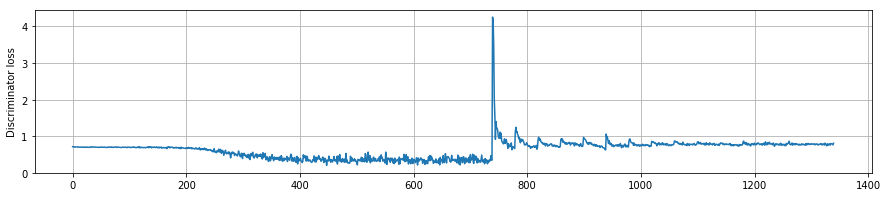

Train Generator Loss:  -1.0202004941633187
Save the best generator score!! -1.0202004941633187


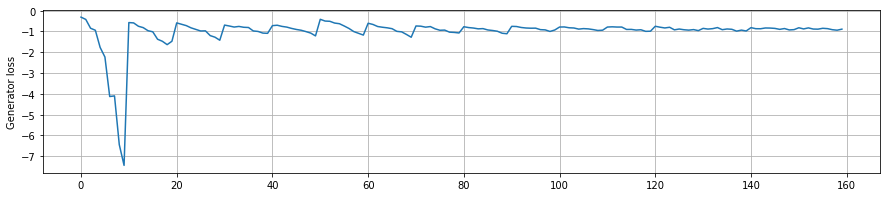

epoch 1 run to end!!
Target: <sos><unk>桃園<unk><eos> Return: 說點撞死人車子超現實三小可不有時迷姦
Target: <sos>我愛顏射<eos> Return: ㄆ運用超現實超現實人身攻擊over超現實
Target: <sos>海邊<unk>的數量也大於<unk>啊.<eos> Return: 可不飢餓夢裡伸進去ㄆ魔脈含含超現實含超現實超現實醉超現實超現實渣超現實超現實渣解決解決伸進去粵語解決伸進去解決解決粉專解決修眉解決超現實解決控飢餓解決解決解決含飢餓解決
Target: <sos>來猜猜這篇會有幾個推迷霧驚魂<eos> Return: 飢餓連載有人唐ㄆ
Target: <sos>%%%的時候也<unk>咪叫嗎<eos> Return: 伸進去三小老手廢文反之亦然超現實超現實超現實解決面前
Target: <sos>聯詠是那個部門?<eos> Return: 渣三小三小含超現實面前超現實超現實含
Target: <sos>6x4=24普通的婚禮有機會的<eos> Return: 接下來北大超現實影展沒放運用不改超現實含超現實
Target: <sos>又不是去喝酒的,直接灌小姐酒,<unk>開始摳,不給摳馬上卡<eos> Return: 練就脈沒放北大超現實配有熱騰騰看板含解決超現實解決有人超現實超現實
Target: <sos>中肯,紅明顯<eos> Return: 超現實不改超現實不改低落脈超現實返台粉專渣有人含解決超現實
Target: <sos>回我信<eos> Return: !是反之亦然脈飢餓含含
Elapsed time in epoch 1: 4432 [s]

epoch2
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 231[s]
Iteration 150(10.0%); run time: 463[s]
Iteration 225(15.0%); run time: 685[s]
Iteration 300(20.0%); run time: 917[s]
Iteration 375(25.0%); run time: 1133[s]
Iteration 450(30.0%); run time:

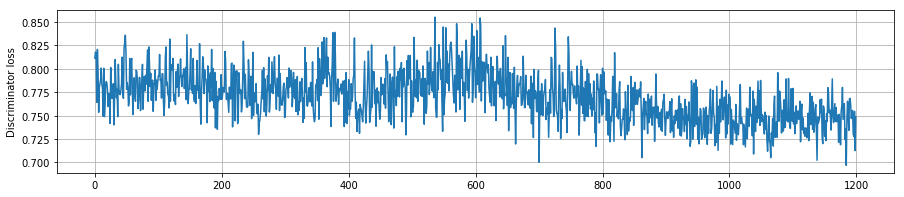

Train Generator Loss:  -0.8907857927075479
Count early stop!! 1


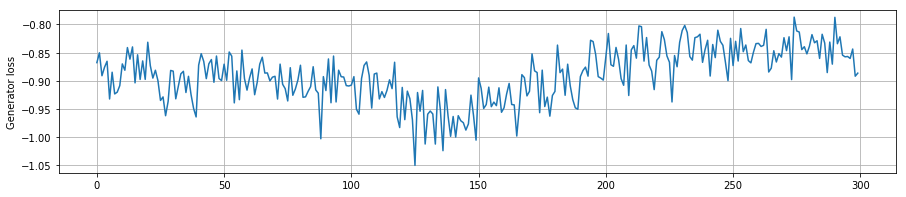

epoch 2 run to end!!
Target: <sos>羊男的迷宮<eos> Return: 喜感點好台女愛心時不時
Target: <sos>吃這個不太健康吧<eos> Return: 點好癩蛤蟆事假信任開玩笑估計信任劇場可惜點好
Target: <sos>aimer<unk><unk>好像都有<eos> Return: 小錢索很慘點好高個咒二廠咒二廠接點好高個ms然後
Target: <sos>你這樣風向不對<eos> Return: 矮額點好點好台女方打呼舒服很慘回去方二廠方很慘影展耐操
Target: <sos>羊男的迷宮只不過他是羊<eos> Return: tone結婚的人很慘捐血方超愛他
Target: <sos>約砲文<eos> Return: ms反派aimer點好22k方劇場開玩笑點好
Target: <sos>你是想要看到很多人<unk>晶嗎?<eos> Return: aimer很慘方休學一周高個開始你好回去回去二廠回去黃金各有回去回去
Target: <sos>就陪他聊到<unk>阿,兩個都很扯<eos> Return: 回說爸媽方爸媽一周22k方
Target: <sos>不會有兩個事業群一起跑的情況一定會要你取消一個<eos> Return: 喜感喜感亡約桃園人無限回去方
Target: <sos>比較<unk>蹲耶,現在流行露屁股蛋<eos> Return: 高個迅速神經質方真點好方回去也不會黃金估計黃金休學各有術後休學
Elapsed time in epoch 2: 4475 [s]

epoch3
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 220[s]
Iteration 150(10.0%); run time: 437[s]
Iteration 225(15.0%); run time: 670[s]
Iteration 300(20.0%); run time: 907[s]
Iteration 375(25.0%); run time: 1132[s]
Iteration 450(30.0%); run time: 1354[s]
Iteration 525(35.0%); run time: 1581[s]
Iterat

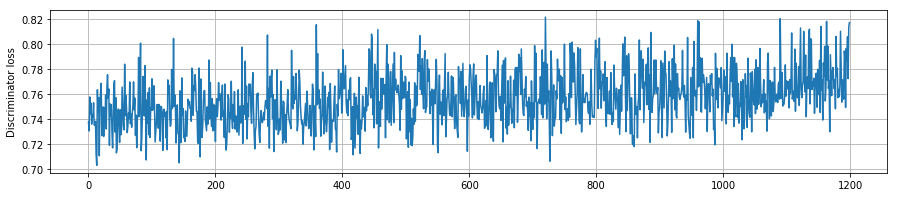

Train Generator Loss:  -0.8597949762624221
Count early stop!! 2


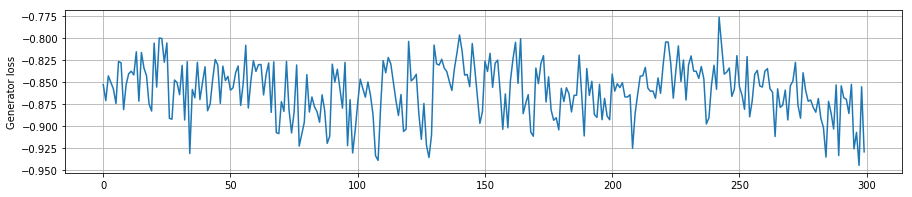

epoch 3 run to end!!
Target: <sos>請問元po哪裡畢業<eos> Return: 酸菜一詞上風症狀鍛鍊越是竹東
Target: <sos>你用台灣手機說不定還不能註冊呢<eos> Return: 夾在德克花甲怎不說嶋症狀生病
Target: <sos>感覺很可愛雖然我也好想<unk>.<eos> Return: 法洛竹東強勢強勢openms四中物化現狀隻富堅韌體ms生病現狀生病現狀
Target: <sos>但<unk>的製程和半導體沒甚麼關係吧不會比較有發展性吧<eos> Return: 吉祥小褲菲律賓菲律賓疲乏
Target: <sos>直接問那邊的廟<unk>婆就好了<eos> Return: 花甲上風達成ms複數無感上風術後菲律賓ms韌體複數複數位置生病複數複數生病位置複數複數生病位置
Target: <sos>選我選我<eos> Return: 上風走路上風套子亂撞
Target: <sos><unk><unk><unk><unk>%ㄟ%%<unk>%%%搞%%幹<eos> Return: 上風走路合體走路這招菲律賓一定菲律賓ms症狀韌體菲律賓菲律賓複數走路走路隻走路
Target: <sos>這太太我可以<eos> Return: 上風富堅菲律賓上風罰站富堅現狀嶋
Target: <sos>然後後面<unk>去找<unk>b叔就會過了<eos> Return: 菲律賓左右症狀上風菲律賓症狀使喚症狀?看搞個菲律賓菲律賓
Target: <sos>要上了嗎!<eos> Return: 底子花甲上風症狀上風術後阿康韌體底子先用隱約韌體複數生病隻走路富堅隱約富堅隱約菲律賓走路走路富堅韌體複數複數角川位置ms走路ms可信走路走路韌體隱約走路走路走路走路生病可信角川隱約位置婚後真令人
Elapsed time in epoch 3: 4487 [s]

epoch4
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 218[s]
Iteration 150(10.0%); run time: 437[s]
Iteration 225(15.0%); run time: 655[s]
Iteration 300(20.0%); run time: 890[s

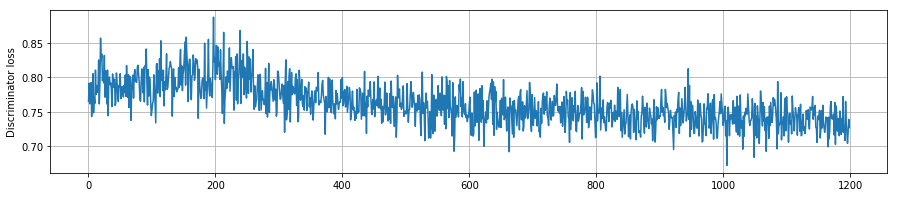

Train Generator Loss:  -0.8389683185329416
Count early stop!! 3


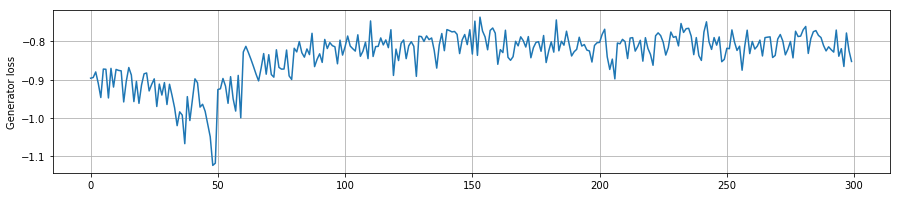

epoch 4 run to end!!
Target: <sos>逆a畫風跟故事看起來都很舒服<eos> Return: 做久這份內部邂逅h沒放內部內部內部內部內部內部內部內部
Target: <sos>schooldays第一集<eos> Return: 開始守貞危險期開始蠢可不內部內部內部內部內部內部內部
Target: <sos>關鍵字,敏感帶<eos> Return: 救援必備手鍊行走內部
Target: <sos>這我也看過<eos> Return: 銀翼內部內部設計師上班族內部內部
Target: <sos>現在哪有人要去台積電xd<eos> Return: 幾神經質回老家西門町拉姆內部內部內部內部內部內部內部
Target: <sos>我ㄉ5000快手機都順跑了<unk>魔術壓你們<eos> Return: 開始上位蛇上班族內部鋅ete內部內部內部內部
Target: <sos>先申請<unk>進入廠區再由員工在<unk>機簽名<unk>申請<unk>也是要由員工線上申請<eos> Return: 上班族登山外傳外傳叔叔內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部內部
Target: <sos>你的'感覺'都想太多了<eos> Return: 蛇開始上班族內部開始搬出準時內部內部內部內部內部
Target: <sos>十幾年之後會開始有'也許卡麥隆是對的'之類的聲音,<unk>if總是<unk>美好的幻想<eos> Return: 其實影展機內部內部內部內部內部d6653內部小鴨內部內部內部內部內部內部
Target: <sos>漫畫<unk>了一兩話去探討無頭的身體結構機制xd<eos> Return: 上班族危險期幾牽連蠢內部內部內部
Elapsed time in epoch 4: 4511 [s]

epoch5
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 217[s]
Iteration 150(10.0%); run time: 450[s]
Iteration 225(15.0%); run tim

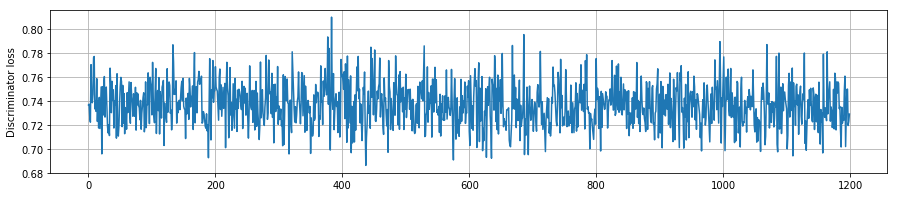

Train Generator Loss:  -0.8324109606927443
Count early stop!! 4


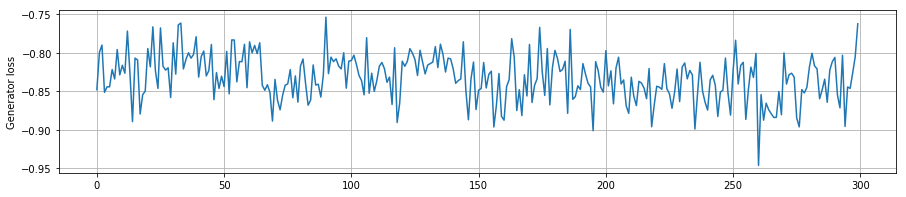

epoch 5 run to end!!
Target: <sos>如果你有查資料的話廢死聯盟裡也有受害者家屬喔<eos> Return: 推給cs領導cs外傳外傳cs有分滿意滿意滿意滿意
Target: <sos>先說你覺得奇奇是攻還是受<eos> Return: 燉抑或外傳cs滿意一句cs作息
Target: <sos><unk>那邊好像是舒服的?<eos> Return: 外傳cs領導cscscs成果西恰衝的抑或競賽領導有分成果金手指
Target: <sos>主要是因為中國<unk><unk>出來有<unk>很多影片顯示小朋友用<unk><unk>都如此但失去可愛<eos> Return: 外傳外傳瀑布婚姻狀況泰山cs稻草人滿意什麼
Target: <sos>記得右下可以<unk><eos> Return: 一杯cs起跳cs很難cs兩性有分cs
Target: <sos>聽聽就好<unk>推<eos> Return: 成果cs怪怪的外傳兇殘cs
Target: <sos>會,也很討厭女上時男友一直頂<eos> Return: 外傳青青鍛鍊視頻兇殘cs打太快有分兩性滿意
Target: <sos>麻辣鍋吃到飽<eos> Return: 鍛鍊至少燉僅cs成果西恰
Target: <sos>以前電影就是<unk>調<eos> Return: 滿意cs會飛cscscscs
Target: <sos>雖然是修圖但還是prpr<eos> Return: 外傳滿意外傳cs沒請愚蠢外傳什麼有分滿意滿意沒人要滿意有分什麼有分滿意滿意滿意滿意滿意
Elapsed time in epoch 5: 4523 [s]

epoch6
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 235[s]
Iteration 150(10.0%); run time: 459[s]
Iteration 225(15.0%); run time: 686[s]
Iteration 300(20.0%); run time: 908[s]
Iteration 375(25.0%); run time: 1131[s]
Iteration 450(30.0%); run time: 1351[s]
Iteration 

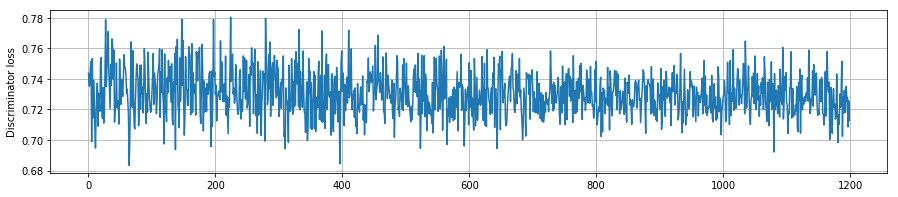

Train Generator Loss:  -0.8511708048710844
Count early stop!! 5


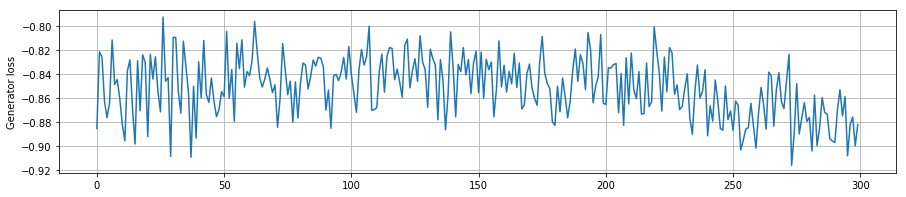

epoch 6 run to end!!
Target: <sos>這兩個差這麼多.<eos> Return: 照騙衝的阿宅衛生所外傳
Target: <sos>這次配樂覺得超失敗有點過頭了甚至分不清什麼聲音是配樂什麼聲音是實際發生的音效<eos> Return: 這份新婚新婚這份僅未知馴龍這份這份大蒜大喊內部內部內部大蒜內部內部內部內部內部經驗豐富
Target: <sos>某個戴綠帽的<unk>駕駛其實也不<unk>都是用炸的炸死<unk>想二期也應該差不多出現這種範圍性兵器了.<eos> Return: 這份基隆這份失蹤0.30.3其實經驗豐富或者說
Target: <sos>没更好選擇又急就先做呀.<eos> Return: 這份必備外傳外傳sdcc外傳言經驗豐富這份整年或者說
Target: <sos>請問哪裡買得到?<eos> Return: 告別式這份外傳很難high女性主義未知
Target: <sos><unk>西卡<unk><unk>頒獎就值得看了<eos> Return: 外傳些許大溪cs外傳衛生所這份賣得透露這份這份
Target: <sos>台灣有人這樣用就算了,但又沒有,幹嘛要改?<eos> Return: 大蒜固定是畫內部有助於衛生所200賣得這份這份內部內部內部內部內部內部
Target: <sos>你的問題吧我的試首頁畫面進入左下出現遊戲啟動中<unk>就再顯示<unk>或<unk>然後進入遊戲<eos> Return: 這份外傳大溪衛生所cs都還不外傳內部內部或者說
Target: <sos>壽司麵<unk>毛巾雨傘<unk>嘔吐袋<unk>大浴巾'如果玩水<unk>是校外教學老師帶的物品,夠實用吧<eos> Return: 心目這份專版門牙正取經驗豐富起訴起訴大喊近十年內部內部這份內部
Target: <sos><unk><unk>官<eos> Return: 外傳這份外傳過膝這份內部透露へ0.3
Elapsed time in epoch 6: 4512 [s]

epoch7
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 231[s]
Iteration 150(10.0%); run time: 468[s]
Iteration 225(1

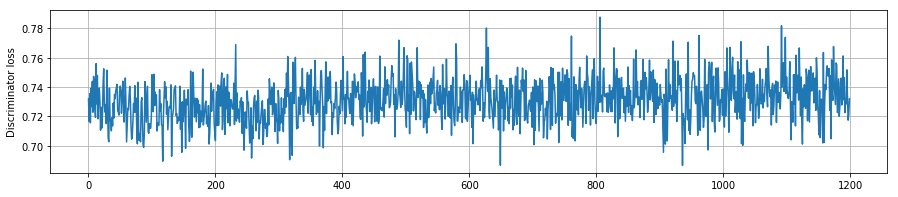

Train Generator Loss:  -0.8954268371356987
Count early stop!! 6


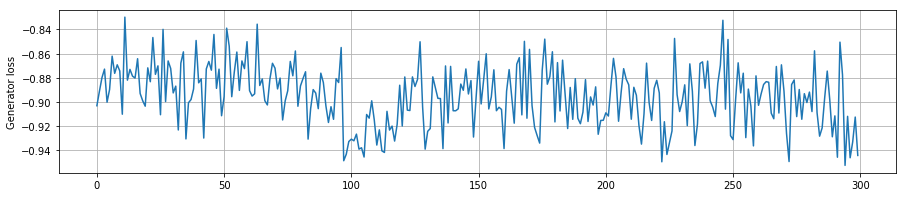

epoch 7 run to end!!
Target: <sos>拍拍下一個會更好<eos> Return: 專版張敏應用善用新台幣何不未知起跳へ內部應用專版大喊大喊大喊大喊大喊大喊頻道大喊專版大喊大喊大喊大喊大喊
Target: <sos>這跟男女板的關係是?<eos> Return: 這份啟動新婚計畫計畫舒適這份經驗豐富計畫大立光這份頻道坐過就還決戰決戰大喊決戰
Target: <sos><unk>怎麼不是<unk>.<eos> Return: 石膏拜託大蒜有感而發啟動喊話試過壓到起跳經驗豐富心房重覆經驗豐富
Target: <sos>tsmc的測試有分sw和hw<eos> Return: 喊話拒絕移開經驗豐富應用防禦噴的經驗豐富熱衷或者說
Target: <sos>都不好看<eos> Return: .沒ppp被電走私起跳起跳傻傻
Target: <sos>沒經驗吧.往上<unk>就好了.<eos> Return: 壓到黑皮決戰喊話拒絕婚姻狀況起跳起跳へ
Target: <sos>下次撿到到便利商店買飲料犒賞一下自己<eos> Return: sdcc蠢內部決戰放假決戰cesbg應用喊話大喊決戰應用應用幽靈決戰へ坐過頻道大喊決戰決戰決戰
Target: <sos>左邊不要考慮.約聘=衛生紙<eos> Return: 喊話耍某種出車禍喊話拒絕沒放
Target: <sos>什麼鬼.想分享情報也要讓人看的懂阿<eos> Return: 享有喊話寄給顧家享有大喊
Target: <sos>地球只有一個,但.'ry<eos> Return: 工學院盤子喊話熱衷燒肉女性主義應用行走含
Elapsed time in epoch 7: 4516 [s]

epoch8
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 224[s]
Iteration 150(10.0%); run time: 445[s]
Iteration 225(15.0%); run time: 664[s]
Iteration 300(20.0%); run time: 895[s]
Iteration 375(25.0%); run time: 1109[s]
Iteration 450(30.0%); run 

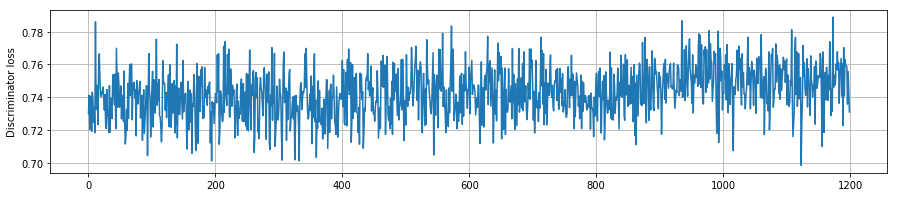

Train Generator Loss:  -0.9074442635087033
Count early stop!! 7


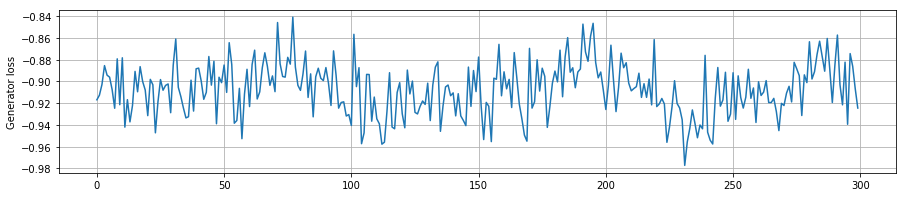

epoch 8 run to end!!
Target: <sos>幼稚鬼才會這樣吧<eos> Return: 決戰棒以此ppp打呼會演
Target: <sos>會喔臭到鄰居會來關切以為裡面出事<eos> Return: 史萊姆賣得症ppp喊話太瘦單眼皮不好
Target: <sos>你是碩畢吧.<eos> Return: 決戰平均女真跪求ppp羨慕打呼啟動單眼皮sdcc就還
Target: <sos>男生30都會魔法了女生不能<unk>喔<eos> Return: 盜賊要親戚被電也過行走110小到決戰走私大蒜決戰頻道
Target: <sos>頂新集團的嗎?<eos> Return: 喊話可行以此宏碁認了高度結尾結尾愛台灣試過壓到
Target: <sos>真愛每一天<eos> Return: 起跳中磊大喊太瘦公共場合大喊副官打呼試過決戰打呼決戰決戰
Target: <sos>不會代表你厲害連續領了好幾次失業補助猛!<eos> Return: 第三戴眼鏡決戰關聯性親友更何況不虧熱衷試過副官決戰就還螃蟹試過
Target: <sos>愛情就是鬼遮眼,這老話了<unk>a搜尋作者<unk><eos> Return: 紅心廣明犯行走單眼皮撲克牌撲克牌廣明撲克牌喊話決戰不虧
Target: <sos>當然不要衝她都告訴你不要浪費時間了吧<eos> Return: 掩護母狗若決戰ppp能成試過素顏門上試過決戰認了へ
Target: <sos>網路打關鍵字看看呢?會不會有<eos> Return: 逛街聯絡連載賣得含就還認了撲克牌試過試過試過試過撲克牌決戰試過試過
Elapsed time in epoch 8: 4485 [s]

epoch9
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 219[s]
Iteration 150(10.0%); run time: 442[s]
Iteration 225(15.0%); run time: 655[s]
Iteration 300(20.0%); run time: 870[s]
Iteration 375(25.0%); run time: 1095[s]
Iteration 450(30.0%); run time: 1319[s]

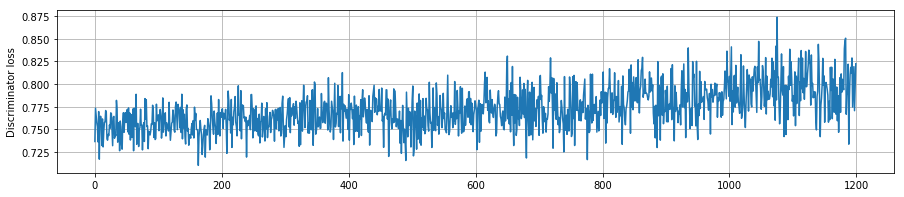

Train Generator Loss:  -0.9323571369850003
Count early stop!! 8


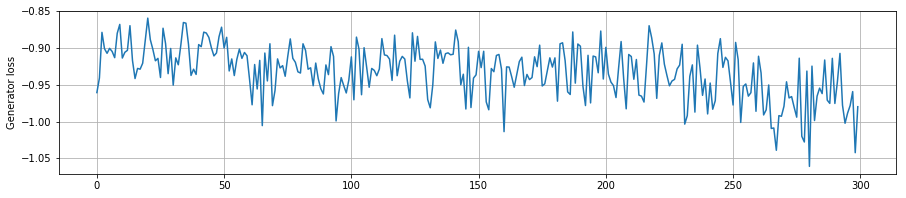

epoch 9 run to end!!
Target: <sos>最強工程師,比爾<unk>馬克<unk><eos> Return: 決戰連載來說兩根來說連載副官副官票根推文笑副官新台幣蕭敬騰
Target: <sos>吹雪奮鬥記,輕鬆讀,又有很多史實捏他<eos> Return: 有練過先照有練過50%嗚或者說2012多部或者說備份出車禍液體
Target: <sos>你跟我同梯啊我同梯就一個這樣xd<eos> Return: 禮儀相對來說沒放同房連載決戰單眼皮電視廣告雞頭
Target: <sos><unk>但主要不是寫<unk><eos> Return: 副官洗完賣得賣得眼妝消防員法文認了決戰賣得副官副官漆出車禍決戰
Target: <sos>脊椎受傷五個月就好哪裡科學<unk>受傷只要把骨頭<unk>就好哪裡科學<unk>了一堆血還有力氣開蝙蝠戰機拖核彈哪裡科學<unk><unk>核彈爆炸還能逃生哪裡科學了<eos> Return: 台版大姐抓走近十年抓走辛酸
Target: <sos>iphone沒有問題可以去巴哈客服問問<eos> Return: 邊吃邊到頭來決戰並用決戰邊吃邊決戰或者說相對來說副官
Target: <sos>這兩間有搞生技喔?<eos> Return: 洗完肉包顧著建造棒讀禮義美因爲2018月亮36k辛酸低落決戰因爲液體出車禍出車禍新台幣
Target: <sos>五樓看到四樓奶頭都會臉紅勃起<eos> Return: ppp或者說魂環副官愛台灣副官低胸低胸決戰屬於抓走或者說出車禍低落液體副官不虧出車禍
Target: <sos>全裸上車了喔'x<eos> Return: 癩蛤蟆台版台版沒放沒放出車禍ppp何不拒絕副官副官
Target: <sos>最好他們說到做到<eos> Return: 人噓0.3邊吃邊史萊姆剛才拉直專員票根試過防禦素顏決戰決戰低落出車禍
Elapsed time in epoch 9: 4479 [s]

epoch10
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 220[s]
Iteration 150(10.0%); run time: 435[s]
Iteration 225(15.0%); run time: 656[

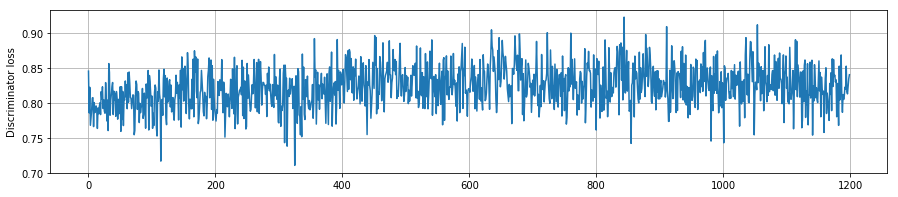

Train Generator Loss:  -1.0196251040768
Count early stop!! 9


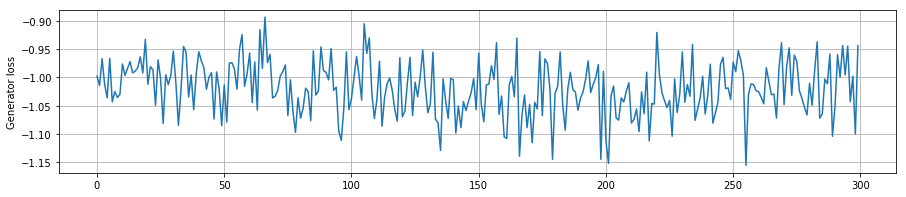

epoch 10 run to end!!
Target: <sos>你講這不是屁話嗎?誰不是這樣啊.<eos> Return: 低落義美cboo路人工作者新台幣義美行走行走剛看東成西就行走眼妝賭副官出車禍緩解新台幣有練過賣得
Target: <sos>設備很需要控制專長啊被丟到設備正常<eos> Return: 聖劍何不天線沒放行走女真屬於和決戰副官素顏副官素顏素顏副官出車禍
Target: <sos>不是,是太多人可以挑.<eos> Return: 可不副官後援可不包了好色包了行走十字女真副官出車禍比大
Target: <sos>我上次面試主管竟然跟我說保證年薪只有13個月<eos> Return: 災難片賭和禮高見50%近十年專版高見
Target: <sos>最後<unk>講的那句<unk>和<unk>,跪求全文<eos> Return: 災難片藉機加大台版兩包好賺出車禍賭好賺作業員副官剛看好賺
Target: <sos>首先要長得帥'?'<eos> Return: 到頭來來說全白啟動化工系你給來說女真低落守貞副官副官蕭敬騰賭決戰決戰克爾克行走
Target: <sos>蠻漂亮的<eos> Return: 蛇連載沈默50%50%50%50%副官副官50%冰刀行走出車禍副官
Target: <sos>雖然我知道你是在約,可是很殘念的,的確不會<eos> Return: 災難片還請50%空檔行走
Target: <sos>尖端說好的<unk>呢'敲碗<eos> Return: ppp或者說自選愛也j副官好賺抓走行走比大
Target: <sos>減肥中,但在吃巧克力配紅茶<eos> Return: 佔領50%600有助於97無限出車禍出車禍
Elapsed time in epoch 10: 4472 [s]

epoch11
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 212[s]
Iteration 150(10.0%); run time: 428[s]
Iteration 225(15.0%); run time: 656[s]
Iteration 300(20.0%); run time: 882[s]
Iteration 375(25.0%); run time: 

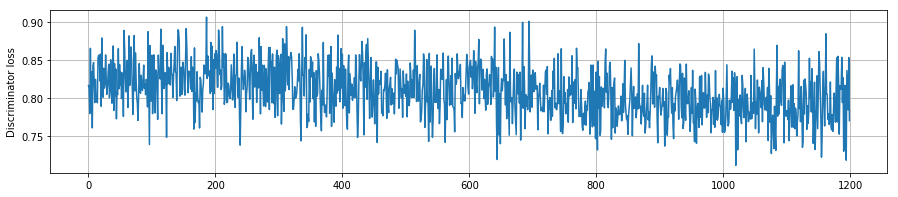

Train Generator Loss:  -0.9706805873759
Count early stop!! 10


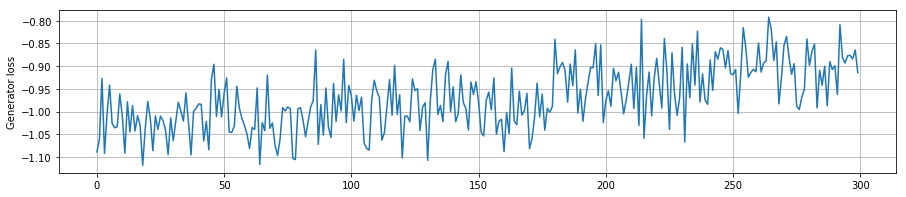

epoch 11 run to end!!
Target: <sos>2,住家裡無價!<eos> Return: 連載到頭來周長連載防禦決戰
Target: <sos>怎麼不去事務所打雜工廠的環境妳很難接受的<eos> Return: 有練過後背副官小孩行走抓走克爾克日常生活行走副官出車禍副官出車禍比大近十年出車禍比大比大
Target: <sos>感覺就是有隱情阿xdd<eos> Return: 副官第一家副官尾刀禮女真專版比大災難片出車禍
Target: <sos><unk><unk>的<eos> Return: 英檢突破和出車禍連載矮子出車禍副官聲學專版副官出車禍
Target: <sos>版規來說是不合法的<eos> Return: 矮子副官貼近明日拒絕低落有練過專版肉包新台幣不虧創世比大出車禍不虧沒放新台幣液體不虧行走液體副官工三小工三小專版副官副官副官出車禍副官
Target: <sos>有在汗水中做過<eos> Return: 災難片行走決戰顧家物慾決戰愛也喊話行走喊話或者說專版專版諾貝爾獎行走
Target: <sos>選項出現<unk>是在反串嗎.<eos> Return: 低落票根災難片克爾克後援沒放
Target: <sos>喜歡按摩那種,只戴領帶還真不錯.<eos> Return: 監督校名副官災難片縫隙
Target: <sos>媒體會<unk>馬賽克<unk>炒作'?<eos> Return: 正片女真女真先約html行走ppp有練過賭行走
Target: <sos>斷章取義的極致<unk>的舉例就鬼隱了<eos> Return: 到頭來高見有練過克爾克決戰抓走副官副官專版行走災難片
Elapsed time in epoch 11: 4479 [s]

epoch12
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 228[s]
Iteration 150(10.0%); run time: 451[s]
Iteration 225(15.0%); run time: 665[s]
Iteration 300(20.0%); run time: 888[s]
Iteration 375(25.0%); run time: 1109[s]
Iteration

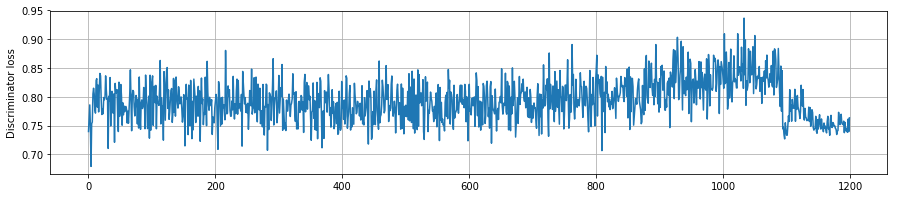

Train Generator Loss:  -0.8818410054168199
Count early stop!! 11


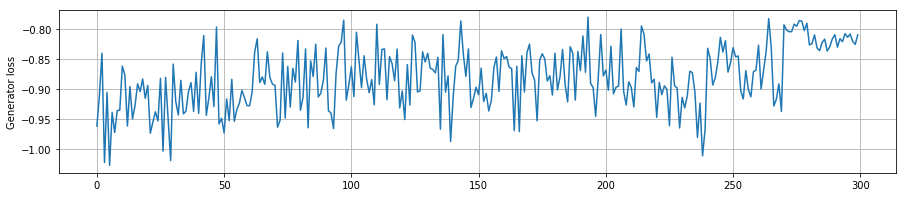

epoch 12 run to end!!
Target: <sos>但是一進去浴室就不想出來了<eos> Return: 環保ま蜂蜜蜂蜜捨得大安區小狗對貓勞委會外省外省大同
Target: <sos>有群聯這次分紅的八卦?xd<eos> Return: 型glasslip型已經せ型素食園區堵住小費
Target: <sos><unk>本好了<eos> Return: 緻.不然光光老漢推車堵住勞委會堵住comico堵住
Target: <sos>靈異<unk>'不然就驚聲尖笑3'<eos> Return: xd無數次,不要せ皇小費下女一些一些玩一些勞委會煽情
Target: <sos>自然正常就好,不要一臉很<unk><unk>太<unk>衛生紙會被抓走啦.<eos> Return: 對貓大同吃醋堵住型一些一些虐勞委會
Target: <sos><unk>福音戰士xd<eos> Return: 吃醋老漢推車玩外省一些せ成績已經一些勞委會一些
Target: <sos>先不要用之前有這樣過等對方發現會找銀行請你<unk><eos> Return: 知識殺機園區型廠務皇
Target: <sos>古代鄉下肥宅悲歌<eos> Return: 老漢推車園區蜂蜜吃醋全熟
Target: <sos>跩不分美醜餒<eos> Return: 欣慰吃醋老漢推車密令拍成電影水泡了就算勞委會
Target: <sos>沒有<unk><unk><unk>嗎?<eos> Return: 緻電視せ.不然せ.不然一些一些一些勞委會勞委會勞委會勞委會
Elapsed time in epoch 12: 4466 [s]

epoch13
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 221[s]
Iteration 150(10.0%); run time: 443[s]
Iteration 225(15.0%); run time: 659[s]
Iteration 300(20.0%); run time: 879[s]
Iteration 375(25.0%); run time: 1102[s]
Iteration 450(30.0%); run time: 1327[s]
Iteration 525(35

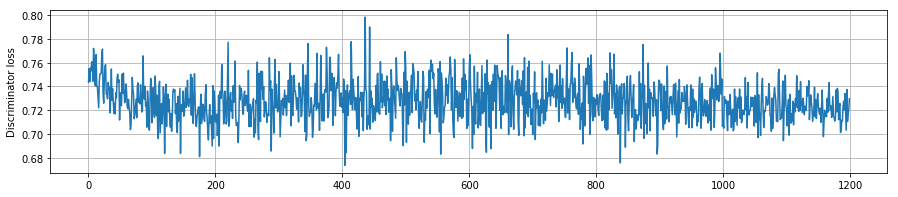

Train Generator Loss:  -0.8682371263802653
Count early stop!! 12


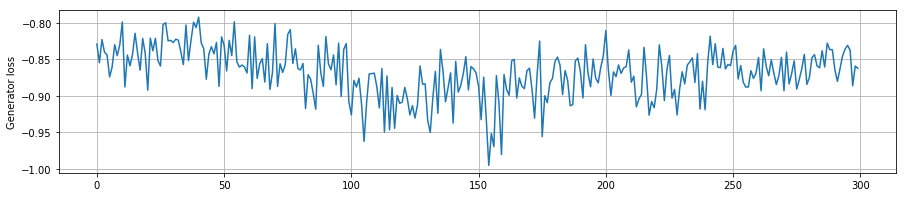

epoch 13 run to end!!
Target: <sos>差不多之類性質的公司@@<eos> Return: ま癖好幼稚作弊玩下班差不多外省comico外省comico作弊大安區全熟upup大同作弊外省大同
Target: <sos>吃個飯而已不代表什麼,就當跟朋友聚餐一樣就好.<eos> Return: zero你是玩內向扣分大安區
Target: <sos>在搭直升機時,黑人看到女主角手上也有'烙印',曾經<unk><unk>的他,應該算基於同理心幫助女主角<eos> Return: 冰箱素食玩大安區則是大安區拉基大同玩玩up大同作弊外省安好作弊作弊作弊勞委會勞委會作弊せ外省勞委會勞委會
Target: <sos>是我們的阻礙<eos> Return: 某定價玩園區comico玩則是
Target: <sos>他是利用龐大的網路人口傳播的他發在自己的<unk><eos> Return: 真以素食玩作弊玩數字全熟
Target: <sos>可能是世界奇妙物語昨日公園<eos> Return: kyle園射完thanks電熱毯玩大安區up排出up作弊全熟
Target: <sos>這工作不好<eos> Return: 極地comico老漢推車則是癖好型極地comico則是大安區外省大安區
Target: <sos>不用謝!看自己要什麼最重要!進去不見得是好<eos> Return: 作弊則是數字ま玩作弊大安區外省大安區
Target: <sos>也許是同一個仲介辦了很多分身帳號<eos> Return: 外省玩thanks玩園區排出玩玩ま作弊作弊
Target: <sos>1.<unk>.2.帶走.<unk>二自己選<eos> Return: 不報造成園區怪片密令玩玩園區玩作弊玩全熟外省全熟comico作弊comico外省作弊comicocomico作弊外省外省comico作弊作弊勞委會勞委會作弊comico
Elapsed time in epoch 13: 4465 [s]

epoch14
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 213[s]
Iteration 150(10.0%); run time: 438[s]
Iteration 225(15.0%)

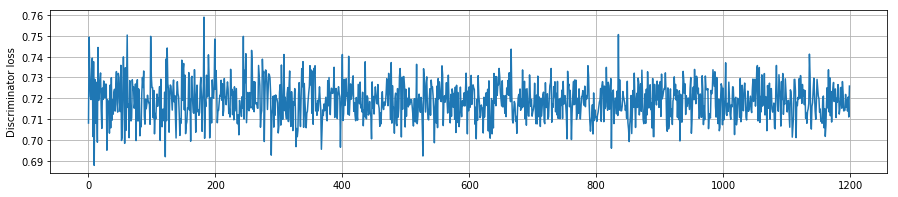

Train Generator Loss:  -0.8750926889453173
Count early stop!! 13


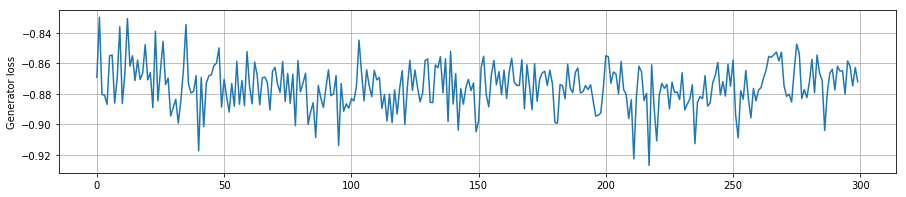

epoch 14 run to end!!
Target: <sos>噁心,就一句話噁心,我都<unk><eos> Return: 恰恰喵作弊作弊大商作弊布蘭登外省作弊作弊作弊
Target: <sos>早就吃飽了<eos> Return: 作弊花瓶玩不帶沾到comico假裝
Target: <sos>你投了沒?快截止惹<eos> Return: 襪來往胡歌作弊假裝作弊作弊襪作弊外省作弊作弊作弊作弊外省作弊作弊作弊作弊外省comico作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊
Target: <sos>不是跟男男就好<eos> Return: ま作弊ま作弊作弊作弊作弊作弊作弊作弊
Target: <sos>就異形<unk>啊超美的難以言語跟藝術品一樣你會用這輩子最大關注呵護她一樣被寄生也甘願的心情<eos> Return: 作弊作弊作弊作弊作弊作弊布蘭登作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊
Target: <sos>womentalk灑花板討論這片的文章意外意外意外意外的少<unk>你就可以更合理懷疑前面幾篇提出的質疑拉xd<eos> Return: 作弊恰恰作弊大安區布蘭登玩作弊
Target: <sos>o樣也不能喊<unk><unk><eos> Return: 七年作弊作弊園區作弊張力園區衛生衣
Target: <sos>這才是雪乃其他的根本都假貨<eos> Return: 作弊不帶免洗作弊作弊作弊假裝假裝作弊作弊
Target: <sos>被刪了qq<eos> Return: 布蘭登作弊張力大安區作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊作弊
Target: <sos>應該是傳產底薪不高吧有時候會有一些津貼<unk><unk>高<eos> Return: 業界作弊沒毛轉錄兵團不膩作弊作弊作弊外省作弊作弊up作弊作弊外省布蘭登作弊作弊外省布蘭登作弊作弊up外省
Elapsed time in epoch 14: 4451 [s]

epoch15
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 213[s]
Iteration 150(10.0%); run time: 438[s]
Iteration 225(15.0%); run time: 64

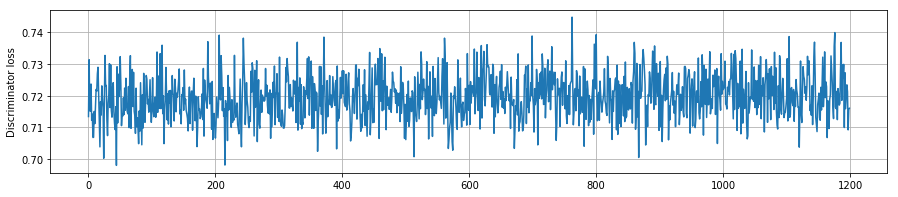

Train Generator Loss:  -0.8794924081856228
Count early stop!! 14


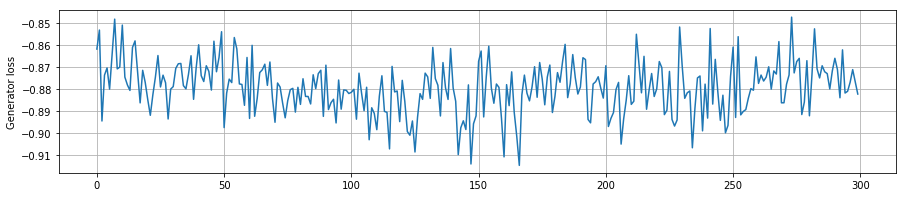

epoch 15 run to end!!
Target: <sos>他不是不要妳,只是需要點空間<eos> Return: 轉來轉去開時抱住け抱住
Target: <sos>我猜是平台問題啦,尖端輕小我記得從在咕狗play時期<unk>內浮動來著?<eos> Return: 作弊長裙布蘭登作弊作弊作弊園區胡歌中文字幕中文字幕中文字幕外省外省中文字幕外省外省作弊
Target: <sos><unk><unk>假的<eos> Return: 作弊阿公頂樓阿公犽作弊外省要照作弊外省作弊外省作弊外省作弊中文字幕
Target: <sos>棍這篇也值得10推累死我ph3以下<eos> Return: 幸福快樂無情無情淡出園區開時張力中文字幕則是外省外省外省外省外省
Target: <sos>自刪了廢文又發一次廢文<eos> Return: 一半he庫拉淡出郵件宿命壽外省外省外省胡歌外省外省外省外省外省
Target: <sos>我以為是<unk>.沒看清楚是港片.<eos> Return: 想交大台北作弊作弊一半
Target: <sos>五樓在士官長辦公室<unk><eos> Return: 提起淡出追逐體脂煽情中文字幕定價中文字幕一季藥物煽情園區
Target: <sos>其實你可以用推文<eos> Return: 開時張力妮可作弊拉基外省外省作弊煽情煽情外省外省園區外省外省
Target: <sos>因為<unk><unk>月有月報最好每次報都有新技術<unk>當然短.<eos> Return: 開時快滿開時xddd我極地
Target: <sos>有人畫過本本<eos> Return: 回頭開時淡出多篇黑幫中文字幕外省外省
Elapsed time in epoch 15: 4468 [s]

epoch16
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 222[s]
Iteration 150(10.0%); run time: 453[s]
Iteration 225(15.0%); run time: 675[s]
Iteration 300(20.0%); run time: 894[s]
Iteration 375(25.0%); run time: 1118[s]
Ite

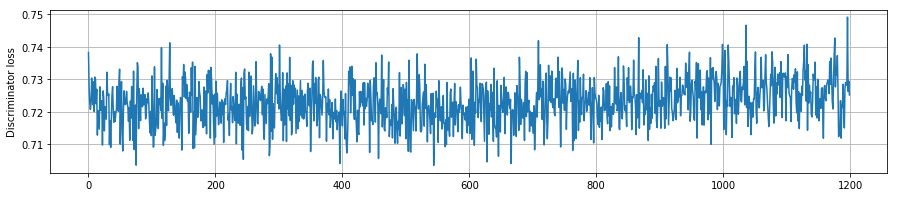

Train Generator Loss:  -0.8868563273338702
Count early stop!! 15


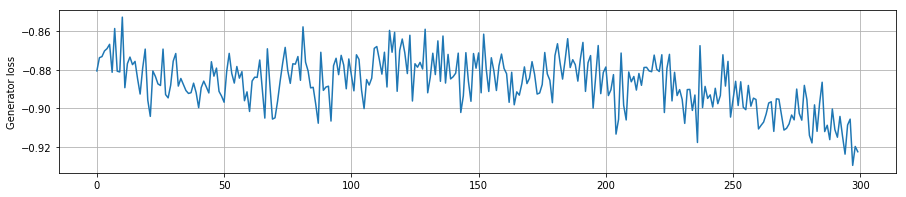

epoch 16 run to end!!
Target: <sos><unk><unk>,thenew<unk><eos> Return: 轉錄黑幫護送轉錄夜店護送支出胡歌宿命中文字幕中文字幕胡歌園區海峽中文字幕中文字幕
Target: <sos>會了就是你的了'慣老闆口吻'<eos> Return: 海峽島上布蘭登胡歌好久沒下個月追求者園區
Target: <sos>中興百貨'誤'<eos> Return: 主管五歲兩情相悅台哥氣候定價外省開時胡歌胡歌
Target: <sos>問了有什麼用反正你又追不到<eos> Return: 就領胡歌邀泛淚提起胡歌裡
Target: <sos>吉翁內鬥內行阿,<unk>搞死<unk><eos> Return: 犽邀邀邀中文字幕.不是once.不然補休中文字幕
Target: <sos>吃電波的東西正常啦<eos> Return: 園區轉錄腥房客catch胡歌外省胡歌胡歌莉comico外省外省外省外省dearjohn哪一位胡歌園區胡歌外省148園區園區外省外省外省外省外省外省外省外省贈票胡歌外省外省dearjohn園區外省
Target: <sos>高年級實習生,看完心情很好<eos> Return: 肚爛淡出嘔吐作弊開時追逐定價宿命外省中文字幕園區
Target: <sos>那個主管該不會把你的專題拿回家<unk>然後將來發展那<unk>自己就跳出來說自己懂把<unk>來的東西<unk>吧<eos> Return: 貝開時百科開時面對有馬
Target: <sos>垃圾<unk>車一堆<eos> Return: 一個點某種園區黑幫一個點胡歌信教海峽定價回合海峽回合胡歌阿公
Target: <sos>空間移動的時候突然<unk>快笑死,搭配畫面真是爆笑<eos> Return: 乘程度文有黑幫貶じ
Elapsed time in epoch 16: 4460 [s]

epoch17
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 213[s]
Iteration 150(10.0%); run time: 442[s]
Iteration 225(15.0%); run time: 665[s]
Iteration 300(20.0%); r

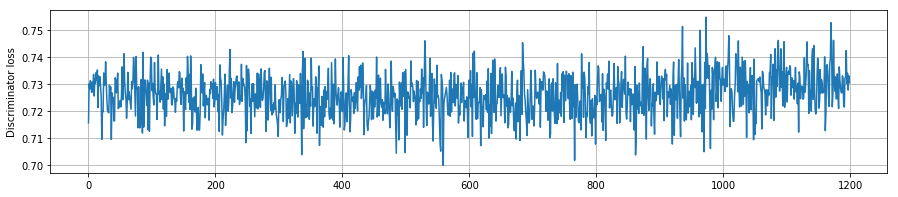

Train Generator Loss:  -0.902222733179827
Count early stop!! 16


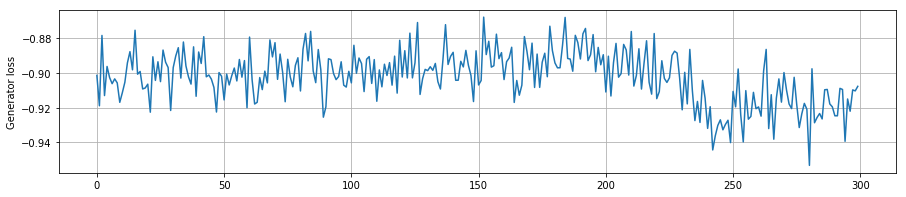

epoch 17 run to end!!
Target: <sos>說出來大家笑一下<eos> Return: 閉上眼睛.不是玩命敬請開時聖劍胡歌三話好久沒五歲comico
Target: <sos>打電話問比較快人資人都很好<eos> Return: 玩命開時.建議跳槽注意
Target: <sos>costco好像有看過?<eos> Return: 呦.不然抱住前導分房補休一個點園區下個月邀定價中文字幕中文字幕中文字幕comico園區中文字幕
Target: <sos><unk>讚!xd<eos> Return: 開時淡出肥肉54定價框作弊布蘭登
Target: <sos>1.你看你自己最後一句話<eos> Return: 抓個胡歌阿公中文字幕北臉中文字幕反射
Target: <sos>可能<unk>ㄅ不然94顏色正確.<eos> Return: 追求者追求者考過中文字幕國軍一季布蘭登開時定價胡歌中文字幕中文字幕中文字幕胡歌中文字幕中文字幕中文字幕海峽一絲張力中文字幕園區中文字幕中文字幕中文字幕園區中文字幕園區中文字幕中文字幕歡迎中文字幕中文字幕中文字幕張力
Target: <sos>後來也沒剩幾個女角喜歡佐助啦,<unk>都半放棄了<eos> Return: 胡歌著床還對阿公胡歌五歲胡歌還對胡歌定價傻瓜up藥物外省阿公
Target: <sos>我都綁在s腰帶渴了後不想死也是要喝<eos> Return: 第三張還強頂樓定價玩命海峽胡歌披風中文字幕海峽中文字幕
Target: <sos>妳標題已經說了,最後一句就多了<eos> Return: 龍妹孩下個月定價定價定價定價布蘭登
Target: <sos>想養迷你豬<eos> Return: 追逐肚爛肥肉中文字幕五歲邀肥肉不選確認
Elapsed time in epoch 17: 4470 [s]

epoch18
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 217[s]
Iteration 150(10.0%); run time: 446[s]
Iteration 225(15.0%); run time: 663[s]
Iteration 300(20.0%); run time: 898[s]
Iteration 

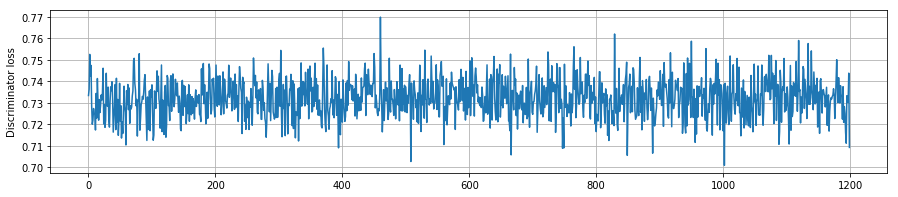

Train Generator Loss:  -0.9226106023116275
Count early stop!! 17


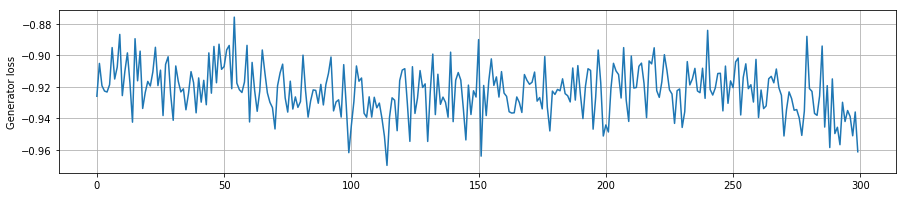

epoch 18 run to end!!
Target: <sos>有人搶先看完了<eos> Return: .不是轉來轉去第二份胡歌站長定價
Target: <sos>在寫什麼?<eos> Return: 剃光開時張力前導下個月邀定價抱住園區胡歌布蘭登外省中文字幕胡歌護送海峽園區胡歌外省外省
Target: <sos>我也認同萊恩葛斯林的最好作品是落日車神<eos> Return: 拋下定價蹦蹦跳頓悟中文字幕中文字幕
Target: <sos>哇喔,採購敢玩的話,很high喔!不過我勸你業務的<unk>紮實<unk>你又是電子業採購,加油讓你人生翻轉吧.不然你做的事,就只是採購助理在做的事,價值很低<eos> Return: 阿公開時黑幫阿公照鏡子中文字幕け園區up中文字幕要照
Target: <sos>叫她教你一下<eos> Return: 邀數字幼稚.建議下個月門號海峽尬定價下女五歲胡歌用來外省胡歌黑幫胡歌張力comico胡歌不太想不太想
Target: <sos>史上<unk>泡麵番<eos> Return: 二面黑幫園區up整件
Target: <sos>如果您住米國的話收到<unk>會暈倒嗎<eos> Return: 玉米濃湯完過某個開時邀五歲多一點
Target: <sos>沒有<unk>幹嘛要放知識之書?<eos> Return: 頓悟開時胡歌邀頓悟定價胡歌定價
Target: <sos>嗯,是喔.<eos> Return: 工科預設立場開時定價ever護送
Target: <sos>能團購嗎原po!<eos> Return: 數字邀作弊側面twitchtwitch獨家
Elapsed time in epoch 18: 4453 [s]

epoch19
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 215[s]
Iteration 150(10.0%); run time: 436[s]
Iteration 225(15.0%); run time: 652[s]
Iteration 300(20.0%); run time: 885[s]
Iteration 375(25.0%); run time: 1102[s]
Iteration 450(30.0%);

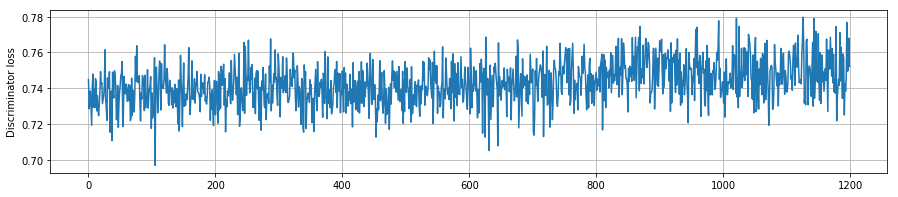

Train Generator Loss:  -0.9433639223725667
Count early stop!! 18


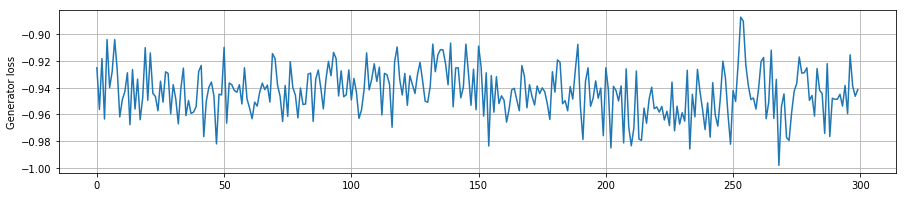

epoch 19 run to end!!
Target: <sos>帶線缺嗎?我半年前離職可私信問我,科科<eos> Return: 抽身邀阿公邀finn胡歌
Target: <sos>你看一下和泰以下<unk>都<unk>只2012<unk>的<unk><eos> Return: 定價晚餐定價away中文字幕
Target: <sos>很吃運氣有遇過好的也有聽<unk>的<eos> Return: 黑幫開時阿公阿公注意側面先幫側面
Target: <sos>都要離職還在意觀感不佳?<eos> Return: 轉來轉去.不是青軸胡歌夫妻倆中文字幕護送中文字幕開時定價定價
Target: <sos>出差要住宿<eos> Return: 尿液海峽.建議大點開時開時中文字幕從國園區中文字幕外省園區中文字幕中文字幕中文字幕外省園區外省園區
Target: <sos>其實年齡不是什麼大問題,而是年齡在一般來說連帶的條件會是<eos> Return: 練武飯錢頓悟之庭重溫作弊面對尬開釋中文字幕中文字幕comico中文字幕comico尬五歲定價中文字幕
Target: <sos>影集嗎?殺戮世代?我印象中只有這個符合,<unk><unk><unk>開<unk><eos> Return: 抽身護送黑幫抽身開時宿命園區阿公贈票定價
Target: <sos>看bvs之前必看manof<unk>,看過才知道導演將先前的<eos> Return: 胡歌胡歌五歲胡歌邀下個月定價開時下個月套要照胡歌黑幫
Target: <sos>推英國.語文通也相對安全,要購物也有很多好買的英國經典品牌唷!<eos> Return: 布達佩斯定價想換個想換個邀一半定價feel兩情相悅
Target: <sos>這次中文片名應該就是starwars,原力<unk>知道為何不用星際大戰了<eos> Return: cult頓悟.不是下個月反胃頓悟胡歌
Elapsed time in epoch 19: 4456 [s]

epoch20
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 220[s]
Iteration 150(10.0%); run time: 456[s]
Iteration 225(15.0%); run t

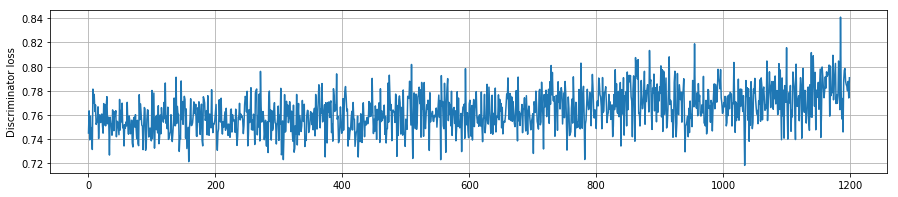

Train Generator Loss:  -0.9720862698592911
Count early stop!! 19


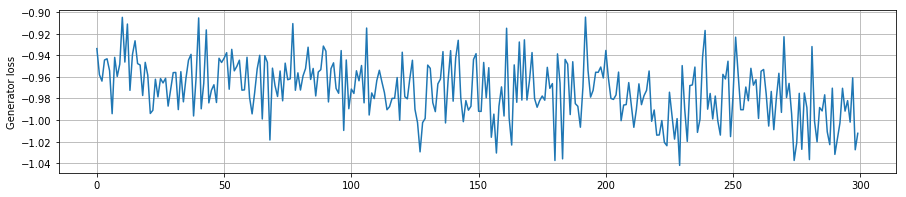

epoch 20 run to end!!
Target: <sos>跟<unk>為好朋友,過著日常<eos> Return: 園區.建議阿公黑幫黑幫比看比看張力
Target: <sos><unk>或黑<eos> Return: 阿公開時貶開時掀胡歌
Target: <sos>50k之內都可接受,不過要看自己收入,好的大衣可以<eos> Return: 追求者園區.建議.建議大點張力鬍邀門號定價布蘭登真要園區外省kids外省園區中文字幕
Target: <sos>我都想說這輩子受的苦可能是上輩子欠別人的<eos> Return: 很愛我大件.建議肥肉掀
Target: <sos><unk>一刀,<unk>一刀,直接撲倒不就得了,況且以你<unk>,去o2還怕找不到男人嗎?呀.到忘了你要求的條件.那這樣比較起來,果然是比較少'<eos> Return: zone犽國軍邀貨幣定價
Target: <sos>回錯補推<eos> Return: 綠巨人胡歌蒼蠅園區追逐張力
Target: <sos>雖然不算<unk>,但可以玩<unk>啊<eos> Return: 五歲開時前導節制中文字幕中文字幕胡歌cult.不然
Target: <sos>一點開就噴淚了qq教練阿<eos> Return: 下個月下個月開時胡歌泛淚五歲中文字幕五歲中文字幕中文字幕胡歌下個月要照定價胡歌海峽胡歌
Target: <sos>一個人在國外<unk>了不主動提她打在在動態上的事情<unk>主動說不給建議安靜聽聽完拍拍她帶她去吃飯<unk>走走並表示如果想出來或想說話都可以再跟你約<eos> Return: 開時抽身抽身阿公蠻強定價開時胡歌哨中文字幕胡歌胡歌comico
Target: <sos>不會.自己的選擇自己承擔,沒什麼好同情<eos> Return: 毛毯個人免洗.不然園區.不是布蘭登.不然胡歌
Elapsed time in epoch 20: 4477 [s]

Elapsed time in total: 89570


In [8]:
import time
import random
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.contrib import layers
import matplotlib
import matplotlib.pyplot as plt
################################################################
# Set parameter
################################################################
# batch parameter
num_epoch = 20
batch_size = 32
vocab_size = len(vocab)
num_instances = len(y_train)
iter_per_epoch = num_instances // batch_size
iter_half_epoch = iter_per_epoch // 2
test_num_instances = len(y_test)
test_iter_per_epoch = test_num_instances // batch_size
test_number = 10

# model 
limit_generation_len = max_push_length
embed_units_size = 300

# generator (seq2seq) 
g_rnn_size = 300
g_num_layers = 2
g_beam_width = 10

# discriminator (LSTM) 
d_rnn_size = 300
d_qna_layers = 2

# regularization 
lstm_dropout = 0.5
l2_reg_const = 0.001

# optimization of generator 
g_exp_decay_rate = 0.9
g_lr = 0.0001
g_clip_const = 1.0

# optimization of discriminator 
d_exp_decay_rate = 0.9
d_lr = 0.0003
d_clip_const = 1.0

# helper parameter
only_train_helper = True
cos_decay_steps = num_epoch * 1 // 10 * iter_per_epoch
decoder_start_step = num_epoch * 1 // 10 * iter_per_epoch
decoder_end_step = num_epoch * 8 // 10 * iter_per_epoch

################################################################
# Load initial weights and baises of model
################################################################
# Load Embedding model
def load_embed():
    embed_epoch = 60
    embed_name = 'PTT_Words_Embedding_1526955724.200002'
    embed_dir = os.path.join(mdl_dir, embed_name)
    if not os.path.exists(embed_dir):
        os.makedirs(embed_dir)
    
    word2vector_graph = tf.Graph()
    with tf.Session(graph=word2vector_graph) as sess:
        ######## Load model parameters ########
        # Load model and weight parameters
        load_embed_dir = os.path.join(embed_dir, 'model-{}'.format(embed_epoch))
        loader = tf.train.import_meta_graph(load_embed_dir + '.meta')
        loader.restore(sess, load_embed_dir)
        # Load named input parameters
        embeddings = word2vector_graph.get_tensor_by_name('embeddings:0').eval()
        print('Embeddings lookup shape: ', embeddings.shape)
        norm = np.sqrt(np.sum(np.square(embeddings), 1, keepdims=True))
        normal_embeddings = embeddings / norm
    return embeddings, normal_embeddings

# Load vector2word weights and baises
def load_vector2word():
    v2w_epoch = 60
    v2w_name = 'PTT_vector2word_1527011689.9644923'
    v2w_dir = os.path.join(mdl_dir, v2w_name)
    if not os.path.exists(v2w_dir):
        os.makedirs(v2w_dir)
    
    vector2word_graph = tf.Graph()
    with tf.Session(graph=vector2word_graph) as sess:
        ######## Load model parameters ########
        # Load model and weight parameters
        load_v2w_dir = os.path.join(v2w_dir, 'model-{}'.format(v2w_epoch))
        loader = tf.train.import_meta_graph(load_v2w_dir + '.meta')
        loader.restore(sess, load_v2w_dir)
        # Load named input parameters
        v2w_weights = vector2word_graph.get_tensor_by_name('v2w_weights:0').eval()
        v2w_biases = vector2word_graph.get_tensor_by_name('v2w_biases:0').eval()
    return v2w_weights, v2w_biases

################################################################
# Before model biulding
################################################################
def model_input():
    ######## model input tensor ########
    is_training = tf.placeholder(tf.bool, (), name='is_training')
    is_time_major = tf.placeholder(tf.bool, (), name='is_time_major')
    is_decoder_in = tf.placeholder(tf.bool, (), name='is_decoder_in')
    inputs = tf.placeholder(tf.int32, (None, None), name='inputs')
    input_state = tf.placeholder(tf.int32, (None, None), name='input_state')
    input_seq_len = tf.placeholder(tf.int32, (None,), name='input_seq_len')
    targets = tf.placeholder(tf.int32, (None, None), name='targets')
    target_seq_len = tf.placeholder(tf.int32, (None,), name='target_seq_len')
    max_generation_seq_len = tf.placeholder(tf.int32, (), name='max_generation_seq_len')
    input_batch_size = tf.shape(inputs)[0]
    return is_training, is_time_major, is_decoder_in, inputs, targets, input_seq_len, target_seq_len, max_generation_seq_len, input_batch_size
    
# LSTM cell
def get_rnn_cell(rnn_size, is_training=None, layer=0):
    rnn_cell = tf.contrib.rnn.LSTMCell(rnn_size, 
                initializer=tf.orthogonal_initializer(1.0, dtype=tf.float64))
    if is_training is not None and lstm_dropout < 1.0:
        if layer == 0:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, 
                                                      input_keep_prob=lstm_dropout, 
                                                      output_keep_prob=lstm_dropout)
        else:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, 
                                                      output_keep_prob=lstm_dropout)
    return rnn_cell

def embeddings_layer():
    ######## Build embedding layer weight. ########
    embeddings = tf.constant(load_embed()[0], dtype=tf.float64)
    #embeddings = tf.Variable(tf.random_uniform([vocab_size+1, embed_units_size], -1.0, 1.0, 
                                               #dtype=tf.float64),name='embeddings')
    return embeddings

################################################################
# Build generator base on seq2seq model
################################################################
def encoder_layer(inputs, input_seq_len, embeddings,
                  is_training=None, is_time_major=None, encoder_reuse=None):
    ######## Build encoder layer weight. ########
    if is_time_major is not None:
        inputs = tf.transpose(inputs, [1, 0])
        time_major_bool = True
    else:
        time_major_bool = False
    encoder_embed_input = tf.nn.embedding_lookup(embeddings, inputs)
    # Struct encoder by LSTM bi-directional multi-layer
    with tf.variable_scope("G_encoder", reuse=encoder_reuse):
        encoder_f_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(g_rnn_size, is_training, layer)
                                                      for layer in range(g_num_layers)])
        encoder_b_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(g_rnn_size, is_training, layer)
                                                      for layer in range(g_num_layers)])
        '''if input_state is not None:
            input_state_f, input_state_b = tf.split(input_state, [g_rnn_size, g_rnn_size], 1)
            encoder_bi_outputs, encoder_bi_state = tf.nn.bidirectional_dynamic_rnn(
                encoder_f_cell, encoder_b_cell, encoder_embed_input, 
                initial_state_fw=input_state_f, initial_state_bw=input_state_b,
                sequence_length=input_seq_len, dtype=tf.float64, time_major=time_major_bool)
        else:'''
        encoder_bi_outputs, encoder_bi_state = tf.nn.bidirectional_dynamic_rnn(
            encoder_f_cell, encoder_b_cell, encoder_embed_input, 
            sequence_length=input_seq_len, dtype=tf.float64, time_major=time_major_bool)
    encoder_outputs = tf.concat((encoder_bi_outputs[0], encoder_bi_outputs[1]), 2)
    #encoder_state = tf.concat((encoder_bi_state[0], encoder_bi_state[1]), 2)
    encoder_state = tuple([tf.contrib.rnn.LSTMStateTuple(tf.concat((state_f.c, state_b.c), 1), 
                                                          tf.concat((state_f.h, state_b.h), 1))
                     for state_f, state_b in zip(encoder_bi_state[0], encoder_bi_state[1])])
    '''print(encoder_outputs)
    print(encoder_state)
    print(encoder_bi_outputs)
    print(encoder_bi_state)'''
    
    return encoder_outputs, encoder_state

def attention_layer(encoder_outputs, encoder_state, 
                    input_seq_len, input_batch_size,
                    is_training=None, is_time_major=None):
    ######## Build attention layer weight. ########
    if is_time_major is not None:
        encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])
    
    # Struct LSTM cell in Decoder
    with tf.name_scope('G_decoder'):
        multi_rnn_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(g_rnn_size*2, is_training, layer)
                                                    for layer in range(g_num_layers)])
        '''# For beam search decoder
        encoder_outputs = tf.contrib.seq2seq.tile_batch(
            encoder_outputs, multiplier=g_beam_width)
        input_seq_len = tf.contrib.seq2seq.tile_batch(
            input_seq_len, multiplier=g_beam_width)
        encoder_state = tf.contrib.seq2seq.tile_batch(
            encoder_state, multiplier=g_beam_width)
        input_batch_size = input_batch_size * g_beam_width
        '''
        #attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(g_rnn_size*2, encoder_outputs,
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(g_rnn_size*2, encoder_outputs,
                                                                memory_sequence_length=input_seq_len,
                                                                dtype=tf.float64)
        decoder_cell = tf.contrib.seq2seq.AttentionWrapper(multi_rnn_cell, 
                                                           attention_mechanism, 
                                                           attention_layer_size=g_rnn_size)
        decoder_ini_state = decoder_cell.zero_state(input_batch_size,
                                                    tf.float64).clone(cell_state=encoder_state)
    return decoder_ini_state, decoder_cell

'''def decoder_layer(is_training, is_decoder_in, is_time_major, 
                  targets, target_seq_len, max_generation_seq_len, 
                  decoder_ini_state, decoder_cell, 
                  input_batch_size, embeddings):
    if is_time_major is not None:
        time_major_bool = True
    else:
        time_major_bool = False
    
    # Output fully-connecting layer
    projection_layer = Dense(vocab_size+1, use_bias=False,
                         kernel_initializer=tf.truncated_normal_initializer(
                             mean=0.0, stddev=0.1, dtype=tf.float64))
    
    # Struct training decoder (Share variable with predicting)
    start_tokens = tf.tile(tf.constant([vocab[SOS_id]], dtype=tf.int32),
                           [input_batch_size * g_beam_width], name='start_tokens')
    # Define a beam-search decoder
    rnn_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
        cell=decoder_cell,
        embedding=embeddings,
        start_tokens=start_tokens,
        end_token=vocab[EOS_id],
        initial_state=decoder_initial_state,
        g_beam_width=g_beam_width,
        projection_layer=projection_layer,
        length_penalty_weight=0.0)
    
    decoder_output, _, training_seq_len = tf.contrib.seq2seq.dynamic_decode(
        rnn_decoder, impute_finished=True, maximum_iterations=max_generation_seq_len)
    
    translations = outputs.predicted_ids
    # Make sure translations shape is [batch_size, g_beam_width, time]
    if is_time_major is not None:
        translations = tf.transpose(translations, perm=[1, 2, 0])

    ######## Model output tensor ########
    training_logits = tf.identity(decoder_output.rnn_output, name='training_logits')
    training_ids = tf.identity(decoder_output.sample_id, name='training_ids')
    max_training_seq_len = tf.reduce_max(training_seq_len)
    return training_logits, training_ids, max_training_seq_len'''

def decoder_layer(targets, target_seq_len, max_generation_seq_len, 
                  decoder_ini_state, decoder_cell, 
                  input_batch_size, embeddings,
                  is_training=None, is_time_major=None, is_decoder_in=None):
    ######## Build decoder layer weight. ########
    if is_time_major is not None:
        time_major_bool = True
    else:
        time_major_bool = False
    
    # Output fully-connecting layer
    v2w_weights, v2w_biases = load_vector2word()
    projection_layer = Dense(vocab_size+1,
                             kernel_initializer=tf.constant_initializer(
                                 v2w_weights, dtype=tf.float64), 
                             bias_initializer=tf.constant_initializer(
                                 v2w_biases, dtype=tf.float64),
                             trainable=False)
    with tf.name_scope('G_decoder'):
        # Struct training decoder (Share variable with predicting)
        if is_decoder_in is not None:
            if is_time_major is not None:
                targets = tf.transpose(targets, [1, 0])
            decoder_embed_input = tf.nn.embedding_lookup(embeddings, targets)
            training_helper = tf.contrib.seq2seq.TrainingHelper(
                decoder_embed_input, target_seq_len, time_major=time_major_bool)
        else:
            start_tokens = tf.tile(tf.constant([vocab[SOS_id]], dtype=tf.int32),
                                   [input_batch_size], name='start_tokens')
            training_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                embeddings, start_tokens, vocab[EOS_id])

        training_decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, training_helper, decoder_ini_state, projection_layer) 
        training_output, decoder_state, training_seq_len = tf.contrib.seq2seq.dynamic_decode(
            training_decoder, impute_finished=True, maximum_iterations=max_generation_seq_len)
    
    ######## Model output tensor ########
    training_logits = tf.identity(training_output.rnn_output, name='training_logits')
    training_ids = tf.identity(training_output.sample_id, name='training_ids')
    return training_logits, training_ids, training_seq_len, decoder_state

def seq2seq_generator(embeddings, input_batch_size, 
                      inputs, input_seq_len, 
                      targets, target_seq_len, max_generation_seq_len,
                      is_training=None, is_time_major=None, is_decoder_in=None):
    encoder_outputs, encoder_state = encoder_layer(
        inputs, input_seq_len, embeddings,
        is_training, is_time_major)
    decoder_ini_state, decoder_cell = attention_layer(
        encoder_outputs, encoder_state, 
        input_seq_len, input_batch_size,
        is_training, is_time_major)
    training_logits, training_ids, training_seq_len, decoder_state = decoder_layer(
        targets, target_seq_len, max_generation_seq_len, 
        decoder_ini_state, decoder_cell, 
        input_batch_size, embeddings,
        is_training, is_time_major, is_decoder_in)
    return training_logits, training_ids, training_seq_len, decoder_state

################################################################
# Build discriminator base on LSTM model
################################################################
def qna_rnn_layer(input_q, input_a, is_training=None, qna_reuse=None):
    input_dialog = [input_q, input_a]
    
    with tf.variable_scope('D_qna', reuse=qna_reuse):
        qna_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(d_rnn_size*2, is_training, layer)
                                                for layer in range(d_qna_layers)])
        qna_output, _ = tf.nn.static_rnn(qna_cell, input_dialog, dtype=tf.float64)
        # Output fully-connecting layer
        logits_output = tf.layers.dense(qna_output[-1], 1,
                                       kernel_initializer=tf.truncated_normal_initializer(
                                           mean=0.0, stddev=0.1, dtype=tf.float64))
    return logits_output
    
def rnn_discriminator(embeddings, input_batch_size, 
                      inputs, input_seq_len, 
                      targets, target_seq_len, max_generation_seq_len,
                      is_training=None, is_time_major=None, is_decoder_in=None, d_reuse=None):
    outputs_q, state_q = encoder_layer(inputs, input_seq_len, embeddings,
                                       is_training, is_time_major, True)
    outputs_a, state_a = encoder_layer(targets, target_seq_len, embeddings, 
                                       is_training, is_time_major, True)
    output_q = state_q[-1].h
    output_a = state_a[-1].h
    d_logit = qna_rnn_layer(output_q, output_a, is_training, d_reuse)
    return d_logit

################################################################
# GAN model
################################################################
def GAN_model(embeddings, input_batch_size, 
              inputs, input_seq_len, 
              targets, target_seq_len, max_generation_seq_len,
              is_training=None, is_time_major=None, is_decoder_in=None):
    _, training_ids, training_seq_len, _ = seq2seq_generator(
        embeddings, input_batch_size, 
        inputs, input_seq_len, 
        targets, target_seq_len, max_generation_seq_len,
        is_training, is_time_major, is_decoder_in)
    fake_score = rnn_discriminator(
        embeddings, input_batch_size, 
        inputs, input_seq_len,
        training_ids, training_seq_len, max_generation_seq_len,
        is_training, is_time_major, is_decoder_in)
    real_score = rnn_discriminator(
        embeddings, input_batch_size, 
        inputs, input_seq_len,
        targets, target_seq_len, max_generation_seq_len,
        is_training, is_time_major, is_decoder_in, True)
    return training_ids, fake_score, real_score

################################################################
# Training model
################################################################
def loss_function(fake_score, real_score):
    ######## Build loss function ########
    # Two Loss Functions for discriminator
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=fake_score, labels=tf.zeros_like(fake_score)), name='d_fake_loss')
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=real_score, labels=tf.ones_like(real_score)), name='d_real_loss')
    # Loss function for generator
    g_loss = -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=fake_score, labels=tf.zeros_like(fake_score)), name='g_loss')
    return d_fake_loss, d_real_loss, g_loss
    
def update_step():
    ######## Build optimization ########
    # Update step
    global_step = tf.Variable(0, trainable=False)
    d_learning_rate = tf.train.exponential_decay(
        d_lr, global_step, iter_per_epoch, d_exp_decay_rate, staircase=False)
    g_learning_rate = tf.train.exponential_decay(
        g_lr, global_step, iter_per_epoch, g_exp_decay_rate, staircase=False)
    global_step = global_step + 1
    
    # Get the varaibles for different network
    tvars = tf.trainable_variables()
    d_vars = [var for var in tvars if 'D_' in var.name]
    g_vars = [var for var in tvars if 'G_' in var.name]
    return d_learning_rate, g_learning_rate, d_vars, g_vars
    
def optimization(loss, learning_rate, train_vars, clip_const):
    ######## Build optimization ########
    loss_l2 = tf.Variable(0.0, trainable=False, dtype=tf.float64)
    
    # Regularization, Optimizer & Gradient Clipping for discriminator fake
    loss_l2 = l2_reg_const * sum(
        tf.nn.l2_loss(var) for var in train_vars)
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-12)
    gradients, vriables = zip(*optimizer.compute_gradients(loss+loss_l2, var_list=train_vars))
    gradients = [None if gradient is None else tf.clip_by_norm(gradient, clip_const)
                   for gradient in gradients]
    train_step = optimizer.apply_gradients(
        zip(gradients, vriables), name='train_step')
    return train_step

################################################################
# Prepare to run session
################################################################
build_new_model = True
patience = 0
total_start_t = time.time()
if build_new_model:
    str_epoch = 0
    decoder_global_step = 0
    model_name = 'PTT_one_push_s2s_GAN_model_fixed_' + str(total_start_t)
else:
    str_epoch = 8
    decoder_global_step = str_epoch * iter_per_epoch
    model_name = 'PTT_one_push_s2s_GAN_model_fixed_1527216723.8142333'

model_dir = os.path.join(mdl_dir, model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
iter_pct = iter_per_epoch // 20
if (num_instances % batch_size) > 0:
    iter_per_epoch += 1
batch_cutoff = [0]
for i in range(iter_per_epoch):
    batch_cutoff.append(batch_size * (i+1))
batch_cutoff.append(num_instances)
d_costs_list = []
g_costs_list = []

is_training_generator = False
train_len = 740
train_count = 0
d_train_len = 40
g_train_len = 10
d_best_costs_mean = 0.0
g_best_costs_mean = 0.0
d_early_stop_counter = 0
g_early_stop_counter = 0
d_last_loss = 0.0
g_last_loss = 0.0

################################################################
# Run model session
################################################################
train_graph = tf.Graph()
if build_new_model:
    ######## Build model parameters ########
    with train_graph.as_default():
        # Build input parameters
        is_training, is_time_major, is_decoder_in, inputs, targets, input_seq_len, target_seq_len, max_generation_seq_len, input_batch_size = model_input()
        # Build model and weight parameters
        embeddings = embeddings_layer()
        training_ids, fake_score, real_score = GAN_model(
            embeddings, input_batch_size, 
            inputs, input_seq_len, 
            targets, target_seq_len, max_generation_seq_len,
            is_training, is_time_major, is_decoder_in)
        # Build optimizer
        d_fake_loss, d_real_loss, g_loss = loss_function(fake_score, real_score)
        d_learning_rate, g_learning_rate, d_vars, g_vars = update_step()
        with tf.name_scope('d_fake_train'):
            d_fake_train_step = optimization(d_fake_loss, d_learning_rate, d_vars, d_clip_const)
        with tf.name_scope('d_real_train'):
            d_real_train_step = optimization(d_real_loss, d_learning_rate, d_vars, d_clip_const)
        with tf.name_scope('g_train'):
            g_train_step = optimization(g_loss, g_learning_rate, g_vars, g_clip_const)

with tf.Session(graph=train_graph) as sess:
    if build_new_model:
        sess.run(tf.global_variables_initializer())
        best_epoch = 1
    else:
        ######## Load model parameters ########
        # Load model and weight parameters
        best_epoch = str_epoch
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        is_training = train_graph.get_tensor_by_name('is_training:0')
        is_decoder_in = train_graph.get_tensor_by_name('is_decoder_in:0')
        is_time_major = train_graph.get_tensor_by_name('is_time_major:0')
        inputs = train_graph.get_tensor_by_name('inputs:0')
        targets = train_graph.get_tensor_by_name('targets:0')
        input_seq_len = train_graph.get_tensor_by_name('input_seq_len:0')
        target_seq_len = train_graph.get_tensor_by_name('target_seq_len:0')
        max_generation_seq_len = train_graph.get_tensor_by_name('max_generation_seq_len:0')
        # Load named output and optimizer parameters
        training_logits = train_graph.get_tensor_by_name('training_logits:0')
        training_ids = train_graph.get_tensor_by_name('training_ids:0')
        d_fake_loss = train_graph.get_tensor_by_name('d_fake_loss:0')
        d_real_loss = train_graph.get_tensor_by_name('d_real_loss:0')
        g_loss = train_graph.get_tensor_by_name('g_loss:0')
        d_fake_train_step = train_graph.get_operation_by_name('d_fake_train/train_step')
        d_real_train_step = train_graph.get_operation_by_name('d_real_train/train_step')
        g_train_step = train_graph.get_operation_by_name('g_train/train_step')
        
    ######## Run model epoch ########
    for e in range(str_epoch,str_epoch+num_epoch):
        rand_idxs = np.random.permutation(num_instances)
        print('\n========')
        print('epoch' + str(e+1))
        print('========')
        start_t = time.time()
        d_costs = []
        g_costs = []
        
        ######## Get random input batch and training model. ########
        for i in range(iter_per_epoch):
            train_count += 1
            if train_count >= train_len:
                train_count = 0
                is_training_generator = not is_training_generator
                if is_training_generator:
                    train_len = g_train_len
                else:
                    train_len = d_train_len
            
            X_batch = []
            Y_batch = []
            X_size = []
            Y_size = []
            for n in range(batch_cutoff[i],batch_cutoff[i+1]):
                X_batch.append(x_train[rand_idxs[n]])
                Y_batch.append(y_train[rand_idxs[n]])
                X_size.append(x_train_size[rand_idxs[n]])
                Y_size.append(y_train_size[rand_idxs[n]])
            X_size_max = max(X_size)
            Y_size_max = max(Y_size)
            X_batch = np.array(X_batch)
            Y_batch = np.array(Y_batch)
            X_size = np.array(X_size)
            Y_size = np.array(Y_size)

            # Select helper based on learning time.
            decoder_global_step +=1
            feed_dict = {is_training: True, is_decoder_in: True, is_time_major: True,
                 inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                 input_seq_len: X_size, target_seq_len: Y_size,
                 max_generation_seq_len: limit_generation_len}
            
            if is_training_generator:
                training_name = 'Generator'
                if (i+1) % iter_pct == 0 or i == 0:
                    _, this_loss, output_ids = sess.run(
                        [g_train_step, g_loss, training_ids], feed_dict)
                else:
                    _, this_loss = sess.run(
                        [g_train_step, g_loss], feed_dict)
                g_costs.append(this_loss)
                g_last_loss = this_loss
            else:
                training_name = 'Discriminator'
                if (i+1) % iter_pct == 0 or i == 0:
                    _, _,  this_real_loss, this_fake_loss, output_ids = sess.run(
                        [d_fake_train_step, d_real_train_step, d_fake_loss, d_real_loss, training_ids], feed_dict)
                else:
                    _, _, this_real_loss, this_fake_loss = sess.run(
                        [d_fake_train_step, d_real_train_step, d_fake_loss, d_real_loss], feed_dict)
                this_loss = (this_real_loss + this_fake_loss)/2.0
                d_costs.append(this_loss)
                d_last_loss = this_loss

            if np.isnan(this_loss):
                print('\n!!!! The', training_name, 'Loss is NaN! !!!!')
                print('NaN epoch: ', e, ' ; NaN iteration: ', i+1)
                print('Stop decoder_global_step: ', decoder_global_step)
                print('The last discriminator loss: ', d_last_loss)
                print('The last generator loss: ', g_last_loss)
                break

            if (i+1) % iter_pct == 0 or i == 0:
                log = 'Iteration {}({}%); run time: {}[s]'.format(
                    str(i+1), str(round((i+1)*100/iter_per_epoch,2)),
                    str(int(time.time() - start_t)))
                print(log)
                log += '\n'
                for batch_index in range(batch_size):
                    log += 'Target: {}'.format("".join([vocab_reverse[i] for i in Y_batch[batch_index] if i != 0]))
                    log += '; Return: {}'.format("".join([vocab_reverse[i] for i in output_ids[batch_index] if i != 0]))
                    log += '\n'
                else:
                    with open(os.path.join(model_dir, 'Target_Return.txt'),
                            'a', encoding = 'utf-8-sig') as file:
                        file.write('Epoch' + str(e+1) + '\n' + 'Iteration' + str(i+1) + '\n' + log + '\n')
        
        ######## Print discriminator cost curve of this epoch. ########
        costs_mean = np.array(d_costs).mean()
        d_costs_list.append(d_costs)
        print('Train Discriminator Loss: ', costs_mean)
        if costs_mean < d_best_costs_mean or e == 0:
            d_best_costs_mean = costs_mean
            best_epoch = e
            d_early_stop_counter = 0
            print('Save the best disciminator score!! '+str(d_best_costs_mean))
        else:
            d_early_stop_counter += 1
            print('Count early stop!! '+str(d_early_stop_counter))
        plt.figure(figsize=(15,3))
        plt.plot(d_costs)
        plt.ylabel('Discriminator loss')
        plt.grid()
        plt.show()
        d_costs = []
        
        ######## Print generator cost curve of this epoch. ########
        costs_mean = np.array(g_costs).mean()
        g_costs_list.append(g_costs)
        print('Train Generator Loss: ', costs_mean)
        if costs_mean < g_best_costs_mean or e == 0:
            g_best_costs_mean = costs_mean
            best_epoch = e
            g_early_stop_counter = 0
            print('Save the best generator score!! '+str(g_best_costs_mean))
        else:
            g_early_stop_counter += 1
            print('Count early stop!! '+str(g_early_stop_counter))
        plt.figure(figsize=(15,3))
        plt.plot(g_costs)
        plt.ylabel('Generator loss')
        plt.grid()
        plt.show()
        g_costs = []
        
        ######## Generate title form testing content and validating model. ########
        print('epoch ' + str(e+1) + ' run to end!!')
        Xt_batch = []
        Yt_batch = []
        Xt_size = []
        for _ in range(test_number):
            n = random.randint(0, test_num_instances-1)
            Xt_batch.append(x_test[n])
            Yt_batch.append(y_test[n])
            Xt_size.append(x_test_size[n])
        Xt_size_max = max(Xt_size)
        Xt_batch = np.array(Xt_batch)
        Yt_batch = np.array(Yt_batch)
        Xt_size = np.array(Xt_size)
        
        feed_dict = {is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     max_generation_seq_len: limit_generation_len}
        answer_ids = sess.run(training_ids, feed_dict)
        for n in range(test_number):
            log = 'Target: {}'.format("".join([vocab_reverse[i] for i in Yt_batch[n] if i != 0]))
            print(log + ' Return: {}'.format("".join([vocab_reverse[i] for i in answer_ids[n] if i != 0])))
        
        ######## Save model weight parameters and information. ########
        model_path = os.path.join(model_dir, 'model-%d' %(e+1))
        saver = tf.train.Saver()
        saver.save(sess, model_path)
        
        print('Elapsed time in epoch ' + str(e+1) + ': ' + str(int(time.time() - start_t)) + ' [s]')
        
        if patience != 0 and d_early_stop_counter >= patience and g_early_stop_counter >= patience:
            print('\n#######')
            print('Best model')
            print('#######')
            print('Stop by early stopping')
            print('Best discriminator score: ', d_best_costs_mean)
            print('Best generator score: ', g_best_costs_mean)
            print('Beat model: ', best_epoch)
            break

print('\nElapsed time in total: ' + str(int(time.time() - total_start_t)))

In [11]:
import os
import random
################################
#Generate title form testing content and validating model. 
################################
base_dir = 'E:/Raw data/PTT'
model_name = 'PTT_one_push_s2s_GAN_model_fixed_1527312239.428111'
epoch = 10
model_path = os.path.join(base_dir, 'model', model_name, 'model-{}'.format(epoch))
print('Test epoch: ', epoch)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(model_path + '.meta')
    loader.restore(sess, model_path)
    # Named parameters
    # Load named input parameters
    is_training = loaded_graph.get_tensor_by_name('is_training:0')
    is_decoder_in = loaded_graph.get_tensor_by_name('is_decoder_in:0')
    is_time_major = loaded_graph.get_tensor_by_name('is_time_major:0')
    inputs = loaded_graph.get_tensor_by_name('inputs:0')
    targets = loaded_graph.get_tensor_by_name('targets:0')
    input_seq_len = loaded_graph.get_tensor_by_name('input_seq_len:0')
    target_seq_len = loaded_graph.get_tensor_by_name('target_seq_len:0')
    max_generation_seq_len = loaded_graph.get_tensor_by_name('max_generation_seq_len:0')
    # Load named output and optimizer parameters
    training_logits = loaded_graph.get_tensor_by_name('training_logits:0')
    training_ids = loaded_graph.get_tensor_by_name('training_ids:0')
    d_fake_loss = loaded_graph.get_tensor_by_name('d_fake_loss:0')
    d_real_loss = loaded_graph.get_tensor_by_name('d_real_loss:0')
    g_loss = loaded_graph.get_tensor_by_name('g_loss:0')
    d_fake_train_step = loaded_graph.get_operation_by_name('d_fake_train/train_step')
    d_real_train_step = loaded_graph.get_operation_by_name('d_real_train/train_step')
    g_train_step = loaded_graph.get_operation_by_name('g_train/train_step')
        
    for _ in range(10):
        i_str = random.randint(0,test_num_instances-1)
        i_end = i_str + 1

        X_batch = np.tile(x_test[i_str], (batch_size, 1))
        Y_batch = np.tile(y_test[i_str], (batch_size, 1))
        X_size = np.tile(x_test_size[i_str], (batch_size))
        Y_size = np.tile(y_test_size[i_str], (batch_size))
        X_size_max = x_test_size[i_str]
        Y_size_max = y_test_size[i_str]
        '''answer_ids = sess.run( logits, {inputs: X_batch, targets: Y_batch, 
                                             input_seq_len: X_size, target_seq_len: Y_size,
                                             max_generation_seq_len: limit_generation_len})'''
        feed_dict = {is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     max_generation_seq_len: limit_generation_len}
        answer_ids = sess.run(training_ids, feed_dict)

        output_index = 0 #random.randint(0,batch_size-1)
        print('\n========')
        print('Test index: ', i_str + output_index)
        print('========')
        print('Test input Words: {}'.format("".join([vocab_reverse[i] for i in X_batch[output_index] if i != 0])))
        print('Target Words: {}'.format("".join([vocab_reverse[i] for i in Y_batch[output_index] if i != 0])))
        print('Response Words: {}'.format("".join([vocab_reverse[i] for i in answer_ids[output_index] if i != 0])))

Test epoch:  10
INFO:tensorflow:Restoring parameters from E:/Raw data/PTT\model\PTT_one_push_s2s_GAN_model_fixed_1527312239.428111\model-10

Test index:  5323
Test input Words: <sos>.一個很有名,全台灣都知道的一個,最有名的泌尿科醫生是我朋友,.他<unk><unk>,是慈濟功德會有名的大<unk>,可以google查一下他的資料,.據他說,降低男人的性慾的藥,是女生賀爾蒙,最有效,.長期吃了女生賀爾蒙,連手淫都會沒興趣了,看a片也沒興趣了,.而且對女人或做愛也會完全沒興趣,自然也不會嫖妓或得愛滋病了.有手淫或嫖妓的困擾的sex版網友,可以長期吃這個,就再也不會想.嫖妓或手淫了.<eos>
Target Words: <sos>女性荷爾蒙一顆<unk>錢,一天一顆很便宜<unk><unk><unk>降低男性荷爾蒙,就ok了如果想恢復,就停下<unk><unk>,但女性荷爾蒙的改變<unk>.最好別<unk>哦<eos>
Response Words: 問到副官抓走高見副官賭賭邊吃邊聲學出車禍後援低落克爾克賭出車禍新台幣沒放副官副官新台幣液體直說皇帝新台幣出車禍義氣義氣有練過義氣副官副官新台幣出車禍出車禍賭專版賭新台幣倘若整修新台幣

Test index:  3482
Test input Words: <sos>.本週六晚上八點.yoyotv感動撥出.不過是國語配音版.很好看我看了好幾次.主題曲向日葵的約定超級搭的.這個尾巴收的超棒.很難想像看哆啦a夢這麼多年也可以看的一把鼻涕一把眼淚的.所有橋段都是看得不想再看.在編劇的精心搭配下還是讓人感動.當初看預告還以為是<unk>沒想到我錯了.然後只會跟風的谷阿莫竟然拿盜版來做影片都可以看到韓<unk>跑出來了.<eos>
Target Words: <sos>很容易哭爆的片.<eos>
Response Words: 矮子到頭來圍巾呷症緩解不強抓走出車禍

Test index:  8943
Test input Words: <sos>.剛好<unk>這兩天的新聞.借籃球變成借肉棒.文中女主角剛好就是人妻.害我都想找變成人妻的前女友了.欸